# <a class="anchor" id="head">Predict Covid-19 cases and fatalities in Chile with data about mobility and socioeconomic background</a>

The Covid-19 pandemic is still having the entire world in its grasp. While in Europe the number of infections decreased during June and July, the cases started to rise in America, both North and South. Especially Chile is one of the most affected countries - [as you can see in my Covid-19-Chile dashboard](http://covid-chile-dashboard.herokuapp.com/) - a fact that has given rise to many critics towards the government.

Based on [my extensive research on the correlation of socioeconomic data and Covid-19 cases and fatalities in Chile](https://medium.com/@muellermax1985/how-do-social-indicators-drive-the-spread-of-covid-19-in-chile-86b0affb0442) in this notebook I will build a model to predict Covid-19 cases and fatalities in Chile. 

As features I will include mobility data from Google and socioeconomic data from the Chilean CASEN study. 

This is how this notebook is structured: 

[Part I: Import libraries, data and explore the data](#part-i)
1. Read in the libraries and data
2. Data exploration and first look

[Part II: Initial data preparation and visualization](#part-ii)
1. DataFrames cases_regions and deaths_regions
2. Preparation and visualization of the CASEN data
3. Preparation and visualization of Google the mobility data

[Part III: Feature analysis - correlation with Covid-19 cases/deaths](#part-iii)
1. Correlation of CASEN socioeconomic indicators with Covid-19 cases/deaths
2. Correlation of Google mobility data with Covid-19 cases/deaths

[Part IV: Build a Machine Learning model for time series prediction](#part-iv)

# <a class="anchor" id="part-i">Part I: Import libraries, data and explore the data</a>

### 1. Read in the libraries and data

This notebook will rely on various data sources: 
* casen: Information about socioeconomic indicators in Chile
* cases_regions: Information about Covid-19 cases in Chilean regions
* deaths_regions: Information about Covid-19 caused fatalities in Chilean regions
* mobility: Information about mobility for different categories provided by Google

In [1]:
# Read in libraries
import pandas as pd
pd.options.mode.chained_assignment = None  

import numpy as np

from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns
sns.set_context('poster')

from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

import sklearn.metrics as metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_log_error

# Read in CASEN data about social vulnerability
# Download: http://observatorio.ministeriodesarrollosocial.gob.cl/casen-multidimensional/casen/basedatos.php
casen = pd.read_stata('Casen 2017.dta', convert_categoricals = False)

# Read in data about Covid-19 cases and deaths in Chilean regions
cases_regions = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto3/CasosTotalesCumulativo_T.csv',
    parse_dates = True)

deaths_regions = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto14/FallecidosCumulativo_T.csv',
    parse_dates = True)

# Read in Google data about mobility
# Download: https://www.google.com/covid19/mobility/
mobility = pd.read_csv('Global_Mobility_Report.csv', dtype = str)

# 2. Data exploration and first look

We will work with the following dataframes: 
* casen: CASEN data
* cases_regions: data about cases per region
* deaths_regions: data about deaths per region
* mobility: data about mobility per country and region

In [2]:
print(casen.shape)
casen.head(2)

(216439, 804)


,folio,o,id_vivienda,hogar,region,provincia,comuna,zona,expr,expc,...,hh_d_estado,hh_d_servbas,hh_d_entorno,hh_d_accesi,hh_d_medio,hh_d_appart,hh_d_tsocial,hh_d_seg,pobreza_multi_4d,pobreza_multi_5d
0,1.101100e+11,1,1.101100e+09,1,1,11,1101,1,39,33,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN
1,1.101100e+11,1,1.101100e+09,1,1,11,1101,1,39,33,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [3]:
print(cases_regions.shape)
cases_regions.head(2)

(174, 18)


,Region,Arica y Parinacota,Tarapacá,Antofagasta,Atacama,Coquimbo,Valparaíso,Metropolitana,O’Higgins,Maule,Ñuble,Biobío,Araucanía,Los Ríos,Los Lagos,Aysén,Magallanes,Total
0,2020-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2020-03-04,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [4]:
print(deaths_regions.shape)
deaths_regions.head(2)

(155, 18)


,Region,Arica y Parinacota,Tarapacá,Antofagasta,Atacama,Coquimbo,Valparaíso,Metropolitana,O’Higgins,Maule,Ñuble,Biobío,Araucanía,Los Ríos,Los Lagos,Aysén,Magallanes,Total
0,2020-03-22,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2020-03-23,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
print(mobility.shape)
mobility.head(2)

(1759411, 14)


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-15,0,4,5,0,2,1
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-16,1,4,4,1,2,1


In [6]:
def first_look(lst):
    """
    Provides useful information about a list of dataframes: Name, Shape, NaNs and describe().
    
    Input: 
        lst(List): List of DataFrames
    
    Output: 
        Prints name, shape, share of NaNs, describe()
    """
    for item in lst:
        def get_df_name(df):
            name =[x for x in globals() if globals()[x] is df][0]
            return name
        print('Information for DataFrame ' + get_df_name(item))
        print('The shape of this DataFrame is {}.'.format(item.shape))
        print('NaN share for each column:')
        print((np.sum(item.isna() == True))/item.shape[0])
        print('Describe() for each column:')
        print(item.describe())
        print('---')

In [7]:
df_list = [casen, cases_regions, deaths_regions, mobility]

first_look(df_list)

Information for DataFrame casen
The shape of this DataFrame is (216439, 804).
NaN share for each column:
folio               0.000000
o                   0.000000
id_vivienda         0.000000
hogar               0.000000
region              0.000000
                      ...   
hh_d_appart         0.005895
hh_d_tsocial        0.000961
hh_d_seg            0.000961
pobreza_multi_4d    0.039933
pobreza_multi_5d    0.045588
Length: 804, dtype: float64
Describe() for each column:
              folio              o   id_vivienda          hogar  \
count  2.164390e+05  216439.000000  2.164390e+05  216439.000000   
mean   8.704111e+11       2.425288  8.704111e+09       1.037392   
std    3.926348e+11       1.462053  3.926348e+09       0.229385   
min    1.101100e+11       1.000000  1.101100e+09       1.000000   
25%    5.804101e+11       1.000000  5.804101e+09       1.000000   
50%    8.401102e+11       2.000000  8.401102e+09       1.000000   
75%    1.310910e+12       3.000000  1.310910e+10   

country_region_code                                   0.000775
country_region                                        0.000000
sub_region_1                                          0.019740
sub_region_2                                          0.196953
metro_area                                            0.993611
iso_3166_2_code                                       0.804288
census_fips_code                                      0.740773
date                                                  0.000000
retail_and_recreation_percent_change_from_baseline    0.367199
grocery_and_pharmacy_percent_change_from_baseline     0.380944
parks_percent_change_from_baseline                    0.527815
transit_stations_percent_change_from_baseline         0.511364
workplaces_percent_change_from_baseline               0.054370
residential_percent_change_from_baseline              0.505332
dtype: float64
Describe() for each column:
       country_region_code country_region        sub_region_1  \
count     

# <a class="anchor" id="part-ii">Part II: Initial data preparation and visualization</a>

## 1. DataFrames cases_regions and deaths_regions

First we will have a look at the DataFrames cases_regions and deaths_regions and plot the numbers of cases and fatalities caused by Covid-19 in Chile. 

In [8]:
def timeline_plot(df, title):
    """
    A function to plot a seaborn diagram which shows the development of Covid-19 data in Chile. 
    For better readability, the function returns a log scale plot. 
    
    Input: 
        df (DataFrame): DataFrame with information about Covid-19 cases/deaths in Chile
        title (string): Specify the kind of the plot (cases or deaths) 
        
    Output: 
        A seaborn plot. 
    """

    # Transform wide dataframe to long dataframe 
    df_melt = pd.melt(
        df, id_vars = 'Region', 
        value_vars = df.columns.drop('Region'),
        var_name='Regions', 
        value_name=title
    )

    # Apply pandas to datetime and rename column for better understanding
    df_melt['Region'] = pd.to_datetime(df_melt['Region'], format = '%Y-%m-%d')
    df_melt = df_melt.rename(columns = {'Region': 'Date'}).sort_values(title, ascending = False)

    # Make a plot 
    f, ax = plt.subplots(figsize = (16, 10))
    
    g = sns.lineplot(
        df_melt.Date, 
        df_melt[title], 
        hue = df_melt.Regions
    )

    plt.xlabel('Date', fontsize = 20)
    plt.ylabel('{} (log scale)'.format(title), fontsize = 20)
    plt.title('Covid-19 {} in Chile (log scale)'.format(title), fontsize = 25)
    
    ax.yaxis.tick_right()
    ax.set_yscale('log')
    plt.tick_params(labelsize=20, rotation=0)
    plt.legend(scatterpoints=1, frameon=True, labelspacing=.2, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)

    plt.grid(False)
    ax.yaxis.grid()
    sns.despine()
    plt.show()

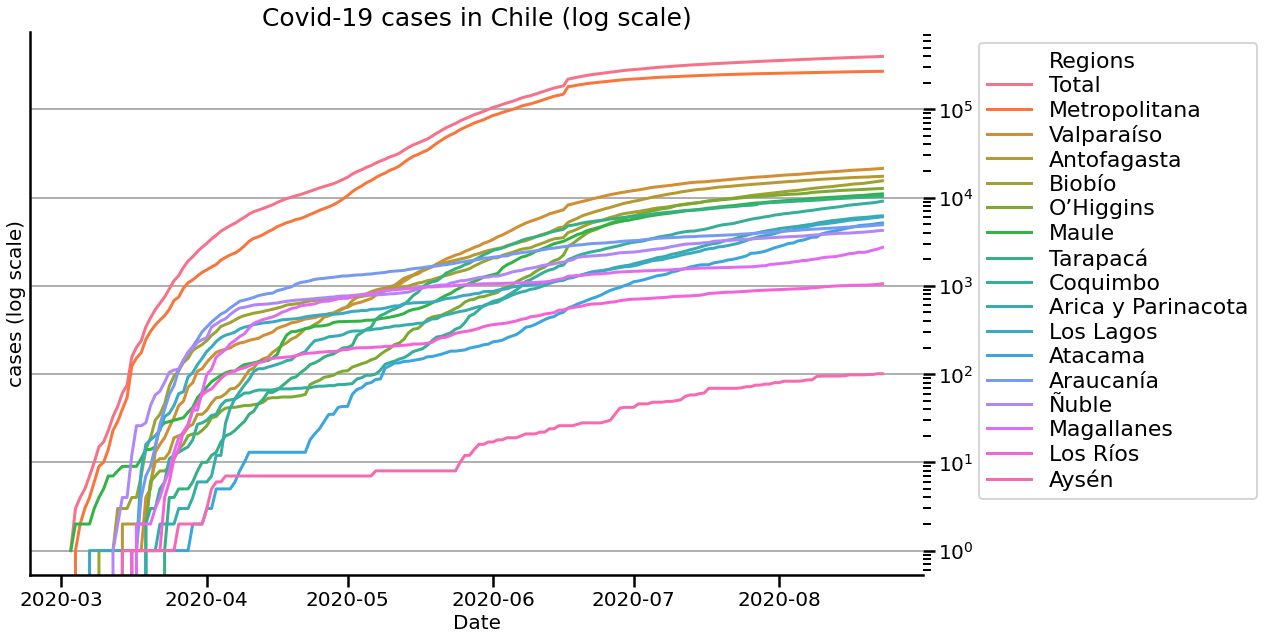

In [9]:
timeline_plot(cases_regions, 'cases')

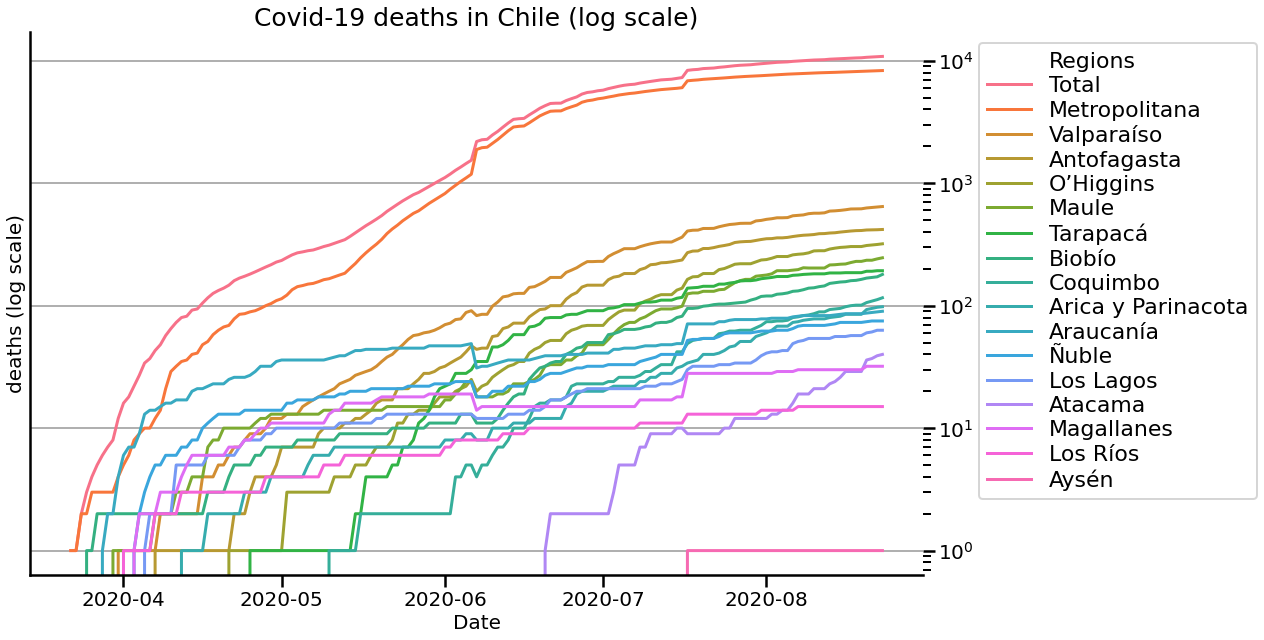

In [10]:
timeline_plot(deaths_regions, 'deaths')

In [11]:
# Convert the 'Region' column of the cases/deaths DataFrames to datetime: 
cases_regions.loc[:, 'Region'] = pd.to_datetime(cases_regions.loc[:, 'Region'])
deaths_regions.loc[:, 'Region'] = pd.to_datetime(deaths_regions.loc[:, 'Region'])

## 2. Preparation and visualization of the CASEN data

Next we will have a look at the CASEN data. As shown before, this DataFrame is very big, with over 800 columns and 200000 rows. 

In [12]:
# Before visualizing the CASEN data, we should have a look at the amount of NaNs. 
# Unfortunately, the CASEN data has a lot of columns with many NaNs: 
(np.sum(casen.isna() == True)/casen.shape[0]).sort_values(ascending = False).head(20)

e9com_p_cod    0.999751
e19_2          0.999580
y2004          0.999501
y20dmonto      0.999501
yama           0.999325
y0512          0.999316
y26_4h_mo      0.999307
yinv02         0.999252
y0511          0.999238
y26_4j_mo      0.999205
yah2           0.999178
y0509          0.999154
yrut           0.999154
y26_4e_mo      0.999099
ydon           0.999085
y0504          0.999039
yre2           0.999011
yre3           0.999011
y20bmonto      0.998826
y2002          0.998826
dtype: float64

In [13]:
def prepare_casen_data(df, col_to_drop, max_nan):
    """
    Function to prepare the CASEN data and realize the following steps: 
    Drop columns that are not necessary (e.g. date of interview), 
    consider only columns with less NaNs than the value of max_nan, 
    fill the rest of the columns with the mean,
    Change the region ID from numbers to names. 
    Print the histogram for four randomly selected columns. 
    
    Input: 
        df (DataFrame): DataFrame with CASEN data
        col_to_drop (list): List with columns that are not necessary
        max_nan (float): maximal value of permitted amount of NaNs in a column
        
    Output: 
        Plots four histograms of four randomly selected columns
        df_rel (DataFrame): DataFrame with CASEN data and without NaNs
    """
    
    # Drop columns that are not necessary
    df_rel = df.drop(col_to_drop, axis = 1)

    # Consider only columns with less NaNs than the value of max_nan
    df_rel = df_rel.loc[:, df_rel.isna().mean() < max_nan]
    df_rel = df_rel.loc[:, df_rel.isin([' ','NULL', 0]).mean() < .2]

    # Fill the rest of the columns with the mean
    df_rel = df_rel.fillna(df_rel.mean())    
    
    # Change the region ID from numbers to names
    df_rel['region'] = df_rel['region'].map({1: 'Tarapacá',
                                               2: 'Antofagasta',
                                               3: 'Atacama',
                                               4: 'Coquimbo',
                                               5: 'Valparaíso',
                                               6: 'O’Higgins',
                                               7: 'Maule',
                                               8: 'Biobío',
                                               9: 'Araucanía', 
                                               10: 'Los Lagos',
                                               11: 'Aysén',
                                               12: 'Magallanes',
                                               13: 'Metropolitana',
                                               14: 'Los Ríos',
                                               15: 'Arica y Parinacota',
                                               16: 'Ñuble'})
    
    # Plot histogram for four randomly selected indicators
    df_rel.sample(4, axis=1).hist(figsize = (12, 8), bins = 25)
    
    return df_rel

,region,zona,tot_hog,tot_per,tot_nuc,pres,pco1,nucleo,pco2,h10a,...,numper,esc,educ,activ,indmat,indsan,calglobviv,iae,iai,hacinamiento
0,Tarapacá,1,1,1,1,1.0,1,1,1,1.0,...,1.0,12.0,5,1.0,1,2,2,1,1,1
1,Tarapacá,1,1,1,1,1.0,1,1,1,1.0,...,1.0,7.0,1,1.0,1,1,1,1,1,1
2,Tarapacá,1,1,2,1,1.0,1,1,1,1.0,...,2.0,12.0,5,1.0,1,1,1,1,1,1
3,Tarapacá,1,1,2,1,3.0,3,1,3,1.0,...,2.0,12.0,5,1.0,1,1,1,1,1,1
4,Tarapacá,1,1,3,1,3.0,1,1,1,1.0,...,3.0,15.0,8,1.0,1,2,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216434,Arica y Parinacota,2,1,2,1,1.0,1,1,1,1.0,...,2.0,3.0,1,3.0,2,2,2,1,1,1
216435,Arica y Parinacota,2,1,2,1,1.0,2,1,2,1.0,...,2.0,4.0,1,1.0,2,2,2,1,1,1
216436,Arica y Parinacota,2,1,2,1,1.0,1,1,1,3.0,...,2.0,12.0,5,3.0,2,2,2,1,1,1
216437,Arica y Parinacota,2,1,2,1,3.0,2,1,2,1.0,...,2.0,3.0,1,1.0,2,2,2,1,1,1


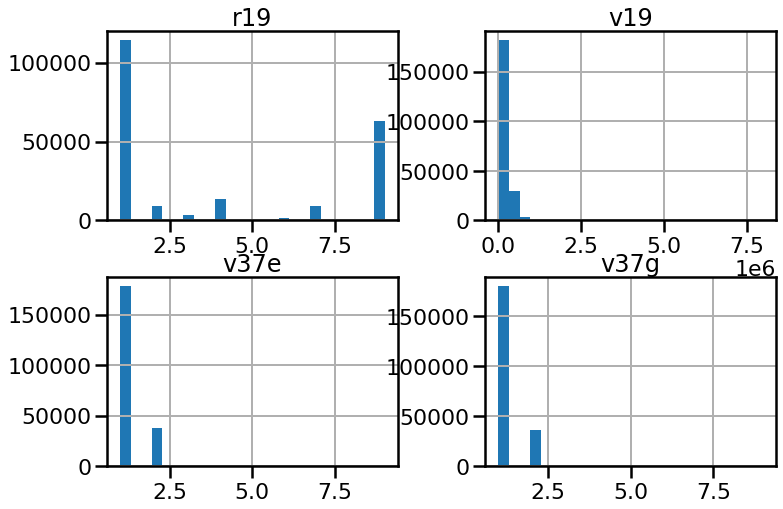

In [14]:
columns = ['folio', 
           'o', 
           'sexo',
           'asiste',
           'edad',
           'pareja', 
           'ecivil',
           'id_vivienda', 
           'hogar', 
           'varstrat', 
           'varunit', 
           'expr_div', 
           'expr', 
           'expc',
           'fecha_dia',
           'fecha_mes',
           'fecha_año',
           'provincia',
           'comuna']

casen_rel = prepare_casen_data(casen, columns, 0.2)

casen_rel

In [15]:
# Group CASEN data by regions by taking the mean of every indicator
casen_regions = casen_rel.groupby('region')[[i for i in casen_rel.columns[1:]]].mean().reset_index()

## 3. Preparation and visualization of Google the mobility data

The Google mobility data contains a lot of useful information for many countries. However, we focus on the data for Chile. 

In [16]:
def prepare_mobility_data(df, country, start, end, include_regions=True, drop_date=True):
    """
    Function to prepare the Google mobility data for any specific country to merge it with the Covid data
    or to plot it. 
    
    Input: 
        df (DataFrame): DataFrame with mobility data
        country (string): Name of the country
        start (string): First day of mobility data
        end (string): Last day of mobility data
        include_regions (bool): Decide if regions should be included. Many countries do not have
        information about the regions, in this case the function would return an empty DataFrame
        drop_date (bool): Decide if 'date' column should be dropped
        
    Output: 
        df_country (DataFrame)
    """

    # Get mobility data for a specific country and leave the rows that are not connected to a region.
    if include_regions == True:
        country_mobility = df[(df['country_region'] == country) & (~df['sub_region_1'].isna())]
    else:
        country_mobility = df[(df['country_region'] == country)]
        
    # Drop columns that are not needed further. 
    country_mobility = country_mobility.drop([
                                'country_region',
                                'country_region_code', 
                                'sub_region_2', 
                                'metro_area', 
                                'iso_3166_2_code', 
                                'census_fips_code'
                            ], axis = 1)
    
    # Rename columns
    country_mobility.columns = ['sub_region_1', 
                                'date',
                                'retail_and_recreation',
                                'grocery_and_pharmacy',
                                'parks',
                                'transit_stations',
                                'workplaces',
                                'residential']
 
    # Convert mobility columns to float.
    info_columns = ['retail_and_recreation',
                   'grocery_and_pharmacy',
                   'parks',
                   'transit_stations',
                   'workplaces',
                   'residential']
    country_mobility[info_columns] = country_mobility[info_columns].astype(float)
  
    # Group mobility data by region and get mean value for each region and date.
    if include_regions == True:
        country_mobility = country_mobility.groupby(['sub_region_1', 'date'])[info_columns].mean().reset_index()
    else: 
        country_mobility = country_mobility.groupby(['date'])[info_columns].mean().reset_index()
    
    # Convert 'date' column to datetime.
    country_mobility.loc[:, 'date'] = pd.to_datetime(country_mobility.loc[:, 'date'])
    
    # Get data for a specific date
    country_mobility = country_mobility[(country_mobility['date'] >= start) & (country_mobility['date'] <= end)]

    
    # Add column 'days' that counts the days from the start. Given that the DataFrame includes 16 regions,
    # the 'days' column should count up to 156 for every region. 
    #country_mobility['days'] = 0   
    #country_mobility = country_mobility.assign(days = np.arange(len(country_mobility)) % 157)
      
    # Drop the 'date' column
    if drop_date == True: 
        country_mobility = country_mobility.drop(['date'], axis = 1)
    else: 
        pass

    return country_mobility

mobility_chile = prepare_mobility_data(mobility, 'Chile', '2020-03-04', '2020-08-07', include_regions=True, drop_date=False)

mobility_chile.head()

,sub_region_1,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
18,Antofagasta,2020-03-04,0.25,8.666667,-11.25,8.25,17.500000,-0.666667
19,Antofagasta,2020-03-05,0.50,6.666667,-13.25,4.75,19.250000,-1.000000
20,Antofagasta,2020-03-06,4.25,7.666667,-9.25,4.50,19.500000,-1.000000
21,Antofagasta,2020-03-07,8.75,8.333333,-9.00,-3.00,5.500000,2.333333
22,Antofagasta,2020-03-08,14.50,23.000000,-1.50,2.50,1.666667,3.333333


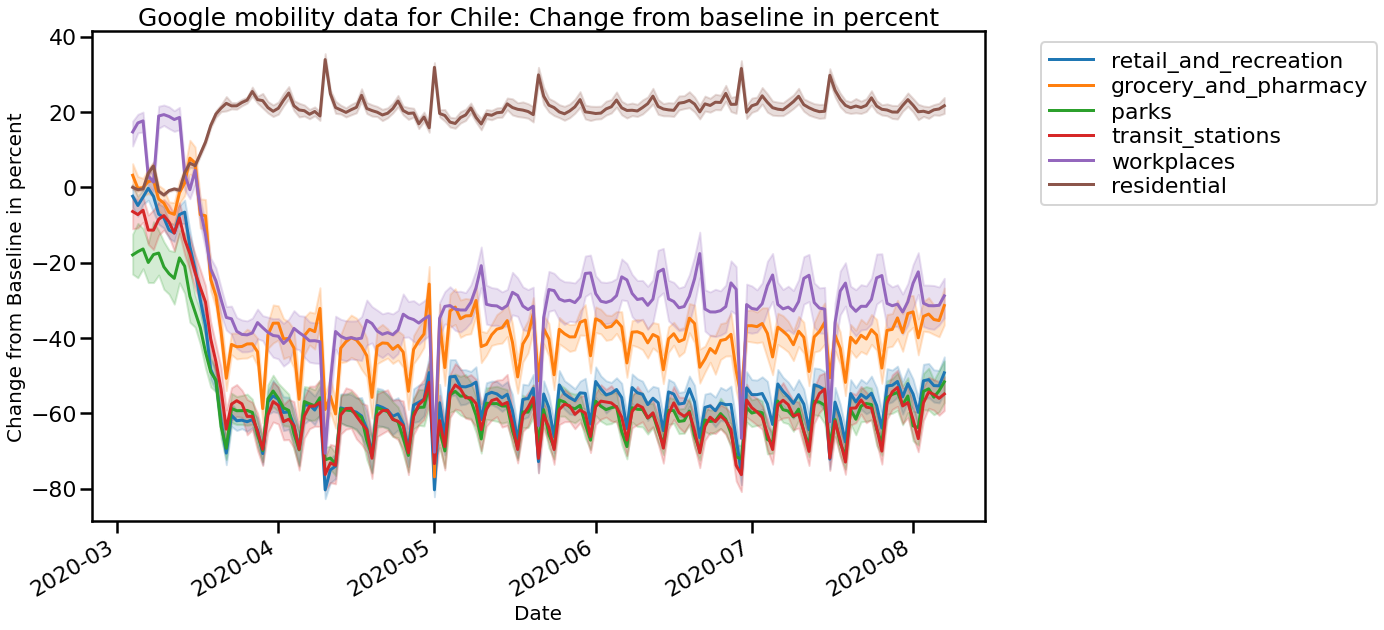

In [17]:
def make_mobility_plot(df, country, start, end, include_regions=False, drop_date=True):
    """
    Function to plot the mobility data for a specific country and for specific start and end dates. 
    
    Input: 
        df (DataFrame): DataFrame with mobility data
        country (string): Name of the country
        start (string): First day of mobility data
        end (string): Last day of mobility data
        include_regions (bool): Decide if regions should be included. Many countries do not have
        information about the regions, in this case the function would return an empty DataFrame
        drop_date (bool): Decide if 'date' column should be dropped
        
    Output: 
        A seaborn lineplot

    """
    
    # Get mobility data for a specific country
    mobility_df = prepare_mobility_data(df, country, start, end, include_regions, drop_date)

    # Rename column names for better readability
    column_names = ['retail_and_recreation',
                   'grocery_and_pharmacy',
                   'parks',
                   'transit_stations',
                   'workplaces',
                   'residential']
    
    # Create figure
    fig, ax = plt.subplots(figsize = (16,10))
    
    # Make a lineplot for each category
    for item in column_names: 
        sns.lineplot(x = mobility_df['date'], y = mobility_df[item])

    # Place legend outside plot
    plt.legend(column_names, scatterpoints=1, frameon=True, labelspacing=.2, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)

    # Define plot title and labels, automatically rotate labels if necessary
    plt.title('Google mobility data for {}: Change from baseline in percent'.format(country), fontsize = 25)
    plt.ylabel('Change from Baseline in percent', fontsize = 20)
    plt.xlabel('Date', fontsize = 20)
    fig.autofmt_xdate()
    
    plt.show()
    
make_mobility_plot(mobility, 'Chile', '2020-03-04', '2020-08-07', include_regions=True, drop_date=False)

In [18]:
# Given that some region names in the mobility data are different from the other datasets, 
# they are changed: 

mobility_chile['sub_region_1'] = mobility_chile['sub_region_1'].map({
                                                'Tarapacá': 'Tarapacá',
                                                'Antofagasta': 'Antofagasta',
                                                'Atacama': 'Atacama',
                                                'Coquimbo': 'Coquimbo',
                                                'Valparaíso': 'Valparaíso',
                                                "O'Higgins": 'O’Higgins',
                                                'Maule': 'Maule',
                                                'Bio Bio': 'Biobío',
                                                'Araucania': 'Araucanía', 
                                                'Los Lagos': 'Los Lagos',
                                                'Aysén': 'Aysén',
                                                'Magallanes and Chilean Antarctica': 'Magallanes',
                                                'Santiago Metropolitan Region': 'Metropolitana',
                                                'Los Ríos': 'Los Ríos',
                                                'Arica y Parinacota': 'Arica y Parinacota',
                                                'Ñuble': 'Ñuble'
                                            })

mobility_chile.head()

,sub_region_1,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
18,Antofagasta,2020-03-04,0.25,8.666667,-11.25,8.25,17.500000,-0.666667
19,Antofagasta,2020-03-05,0.50,6.666667,-13.25,4.75,19.250000,-1.000000
20,Antofagasta,2020-03-06,4.25,7.666667,-9.25,4.50,19.500000,-1.000000
21,Antofagasta,2020-03-07,8.75,8.333333,-9.00,-3.00,5.500000,2.333333
22,Antofagasta,2020-03-08,14.50,23.000000,-1.50,2.50,1.666667,3.333333


# <a class="anchor" id="part-iii">Part III: Feature analysis - correlation with Covid-19 cases/deaths</a>

## 1. Correlation of CASEN socioeconomic indicators with Covid-19 cases/deaths

In [19]:
def get_transposted_df(df, title):
    
    """
    To analyze the correlation between Covid-19 cases/deaths and the CASEN data, 
    it is necessary to transpose the Covid-19 cases/deaths DataFrame. 
    
    Input: 
        df (DataFrame): DataFrame that should be transposed. 
        title (string): Specific if DataFrame is with data about cases or deaths
        
    Output: 
        transposed_df (DataFrame): Transposed version of the DataFrame. 
    """
    
    # Prepare df by transposing it (name of regions as rows)
    transposed_df = (np.transpose(df))
    
    # Change column names to dates
    transposed_df.columns = transposed_df.iloc[0, :]

    # Drop first row (no information)
    transposed_df = transposed_df.drop('Region', axis = 0).reset_index()
    transposed_df = transposed_df.rename(columns = {'index': 'region'})
    
    return transposed_df

transposed_cases = get_transposted_df(cases_regions, 'cases')
transposed_deaths = get_transposted_df(deaths_regions, 'deaths')

In [20]:
def merge_data(transposed_df, input_data, title, input_casen=True):
    """
    Function to merge the CASEN data with a transposed DataFrame. 
    
    Input: 
        transposed_df (DataFrame): Transposed DataFrame with information about Covid-19 cases/deaths.
        casen_data (DataFrame): The CASEN data that should be merged with the transposed DataFrame. 
        title (string): Specific if DataFrame is with data about cases or deaths.
        
    Output: 
        merged_data (DataFrame): A DataFrame with the mean of indicator for each region and 
        information about the most recent amount of Covid-19 cases/deaths.
    
    """
    
    # Given that the DataFrame is updated every day, the name of the last column (the 
    # current amount of Covid-19 cases/deaths) changes every day. 
    last_column = transposed_df.columns[-1]
    
    # Store only the name of the region and the last column as new DataFrame
    df_result = transposed_df.loc[:, ['region', last_column]]
    df_result = df_result.rename(columns = {last_column: title})



    if input_casen == True:
        
        # Group CASEN data by regions by taking the mean of every indicator
        casen_regions = input_data.groupby('region')[[i for i in input_data.columns[1:]]].mean().reset_index()
        
        # Merge CASEN data and information about amount of Covid-19 cases/deaths
        casen_merged = casen_regions.merge(df_result, on = 'region')
        
        # Change type of title column to float
        casen_merged[title] = casen_merged[title].astype('float')
        
        merged_data = casen_merged
        
    else: 
        
        # Group mobility data by regions by taking the mean of every indicator
        mobility_grouped = input_data.groupby('sub_region_1')[['retail_and_recreation', 
                                                               'grocery_and_pharmacy',
                                                               'parks',
                                                               'transit_stations',
                                                               'workplaces',
                                                               'residential']].mean().reset_index()
        
        # Merge mobility data and inofrmation about amount of Covid-19 cases/deaths
        mobility_merged = mobility_grouped.merge(df_result, left_on = 'sub_region_1', right_on = 'region')
        
        # Change type of title column to float
        mobility_merged[title] = mobility_merged[title].astype('float')
        
        merged_data = mobility_merged

    return merged_data

casen_merged_cases = merge_data(transposed_cases, casen_rel, 'cases', input_casen=True)
casen_merged_deaths = merge_data(transposed_deaths, casen_rel, 'deaths', input_casen=True)


In [21]:
def get_corr(casen_merged, title):
    """
    Function to get the correlation between the CASEN socio-economic indicators and the number 
    of Covid-19 cases/deaths in Chile. 
    
    Input: 
        casen_merged (DataFrame): A DataFrame with the mean of indicator for each region and 
        information about the most recent amount of Covid-19 cases/deaths.
        title: Specify the kind of the plot (cases or deaths).
        
    Output: 
        corr (series): Series with pairwise correlation of CASEN indicators with amount of 
        Covid-19 cases/deaths in Chile. 
    """
    
    # Drop 'region' column from casen_merged, as it is not needed here. 
    casen_merged = casen_merged.drop('region', axis = 1)

    # Get correlation with title and sort values from highest correlation to lowest
    corr = casen_merged.corrwith(casen_merged[title]).sort_values(ascending = False)
    
    return corr

In [22]:
get_corr(casen_merged_cases, 'cases')

cases         1.000000
v38e          0.694030
r1b           0.675464
v39e          0.652335
yauth         0.628063
                ...   
v2           -0.415985
calglobviv   -0.421007
v37c         -0.422845
v37g         -0.442164
v37i         -0.610241
Length: 159, dtype: float64

In [23]:
get_corr(casen_merged_deaths, 'deaths')

deaths        1.000000
r1b           0.677448
v38e          0.677301
v39e          0.649298
yauth         0.633046
                ...   
ch1          -0.408276
v37c         -0.419929
calglobviv   -0.421505
v37g         -0.437836
v37i         -0.605191
Length: 159, dtype: float64

In [31]:
def plot_indicator_vs_amount(transposed_df, casen_data, title, high, low):
    """
    Function to prepare a scatterplot of the amount of Covid-19 cases/deaths vs. the CASEN indicators
    with highest and lowest correlation. 
    
    Input: 
        transposed_df (DataFrame): Transposed DataFrame with information about Covid-19 cases/deaths.
        casen_data (DataFrame): The CASEN data that should be merged with the transposed DataFrame.
        title: Specify the kind of the plot (cases or deaths).
    
    Output: 
        Seaborn plots of cases vs. specific indicator. 
    """
    

    highest = list(get_corr(merge_data(transposed_df, casen_data, title, input_casen=True), title).index[1:high])
    lowest = list(get_corr(merge_data(transposed_df, casen_data, title, input_casen=True), title).index[low*-1:])

    casen_sel = casen_data[['region'] + highest + lowest]

    df_plot = merge_data(transposed_df, casen_sel, title, input_casen=True)

    #fig = plt.figure()

    for item in (highest + lowest):

        fig = plt.figure(figsize = (13, 10))

        ax = sns.scatterplot(x = df_plot[item], y = df_plot[title], sizes = (300, 1000), size = df_plot[title], hue = df_plot['region'])
        plt.title('Scatterplot for {} vs. indicator: {}'.format(title, item), fontsize = 25)
        plt.ylabel(title, fontsize = 20)
        plt.xlabel('Indicator: {}'.format(item), fontsize = 20)
        ax.yaxis.grid()
        sns.despine()
        plt.legend(scatterpoints=1, frameon=True, labelspacing=0.2, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        plt.show()

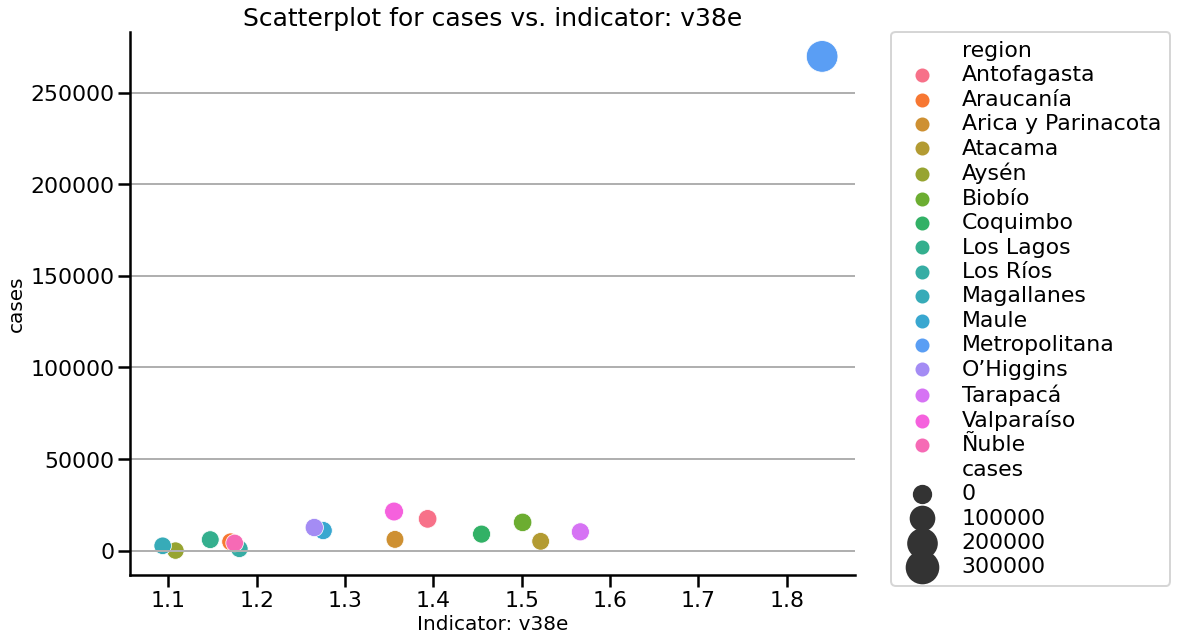

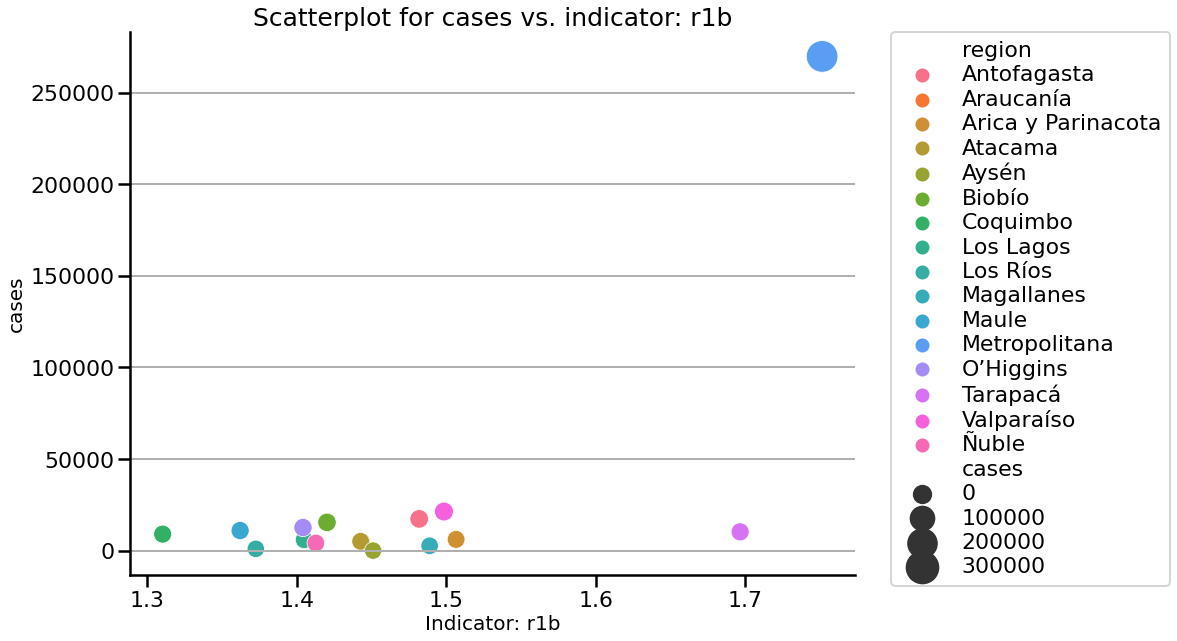

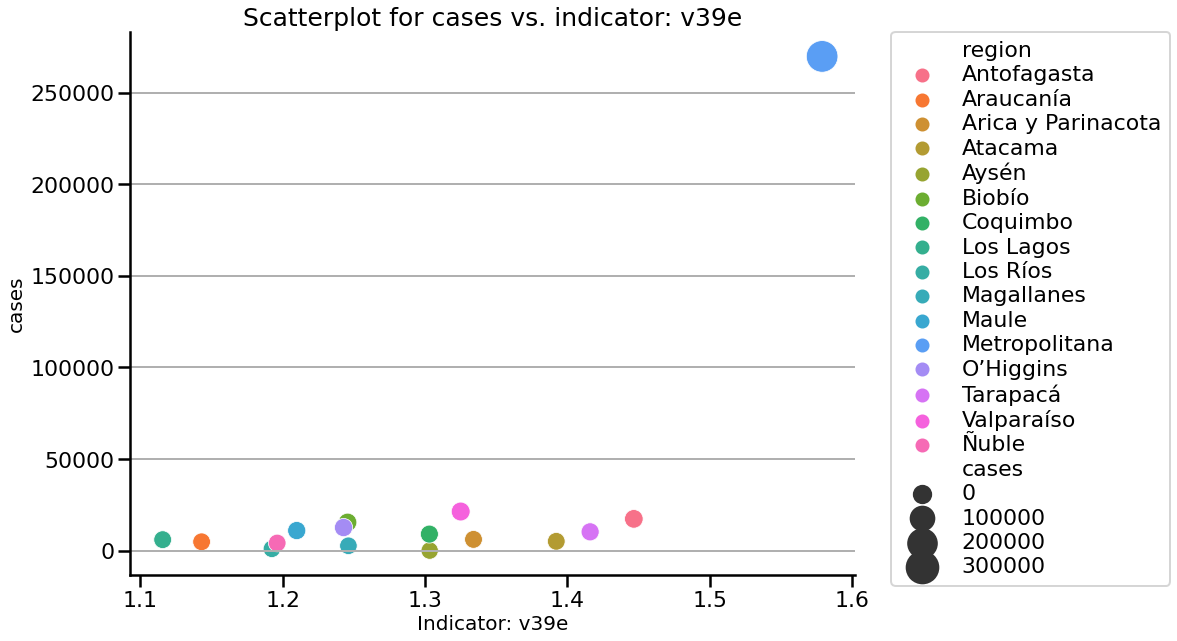

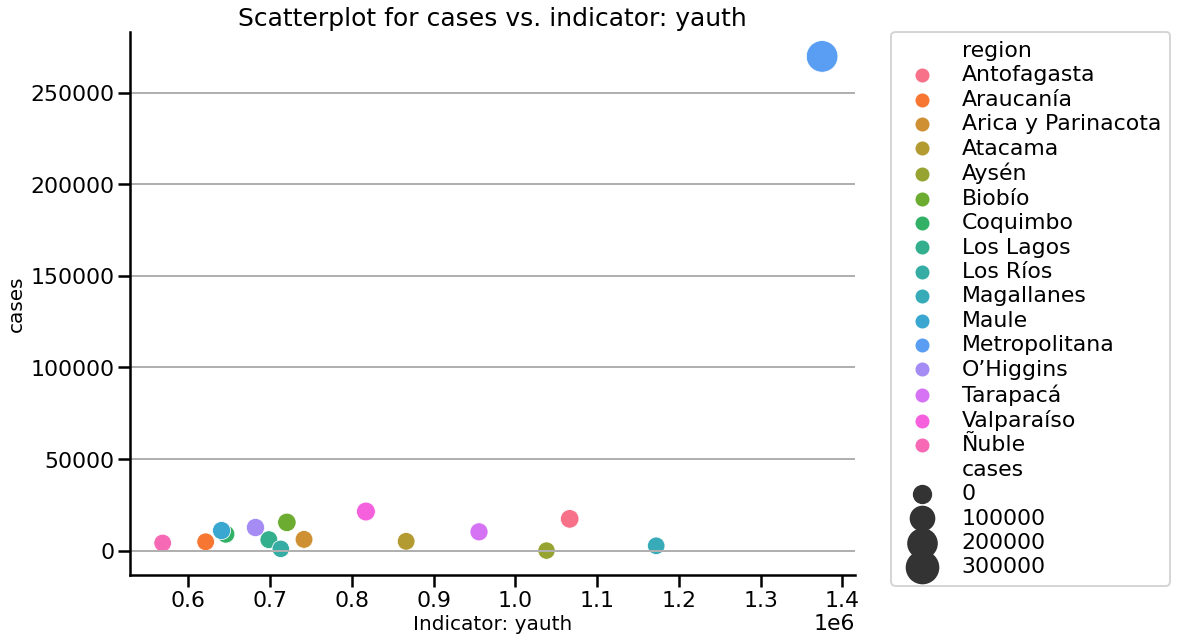

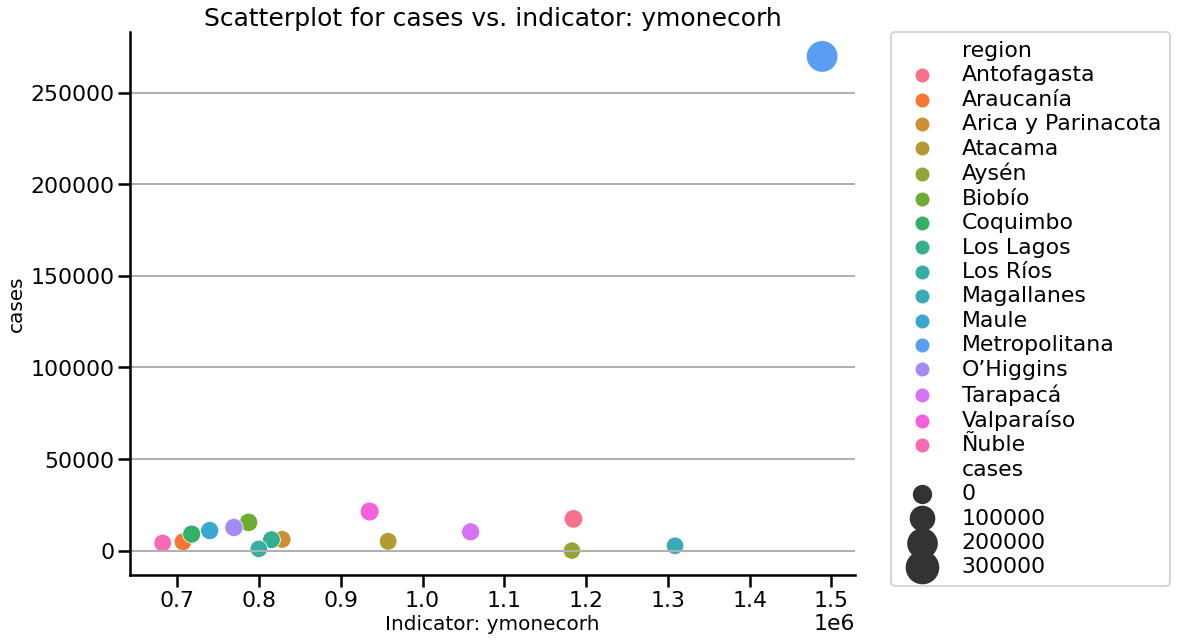

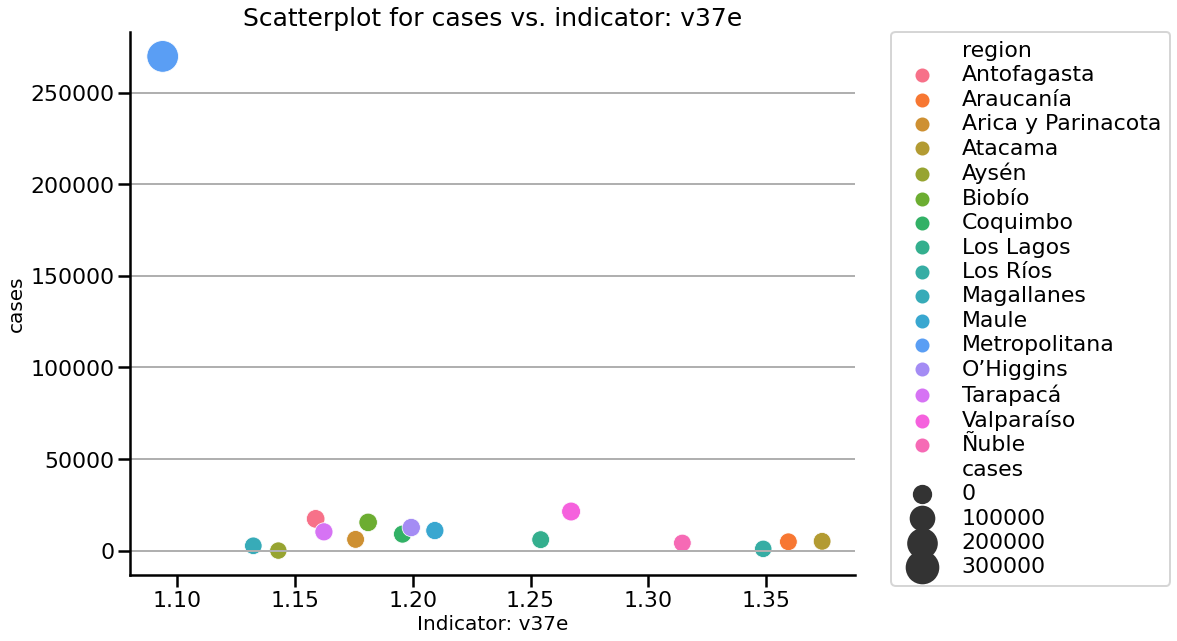

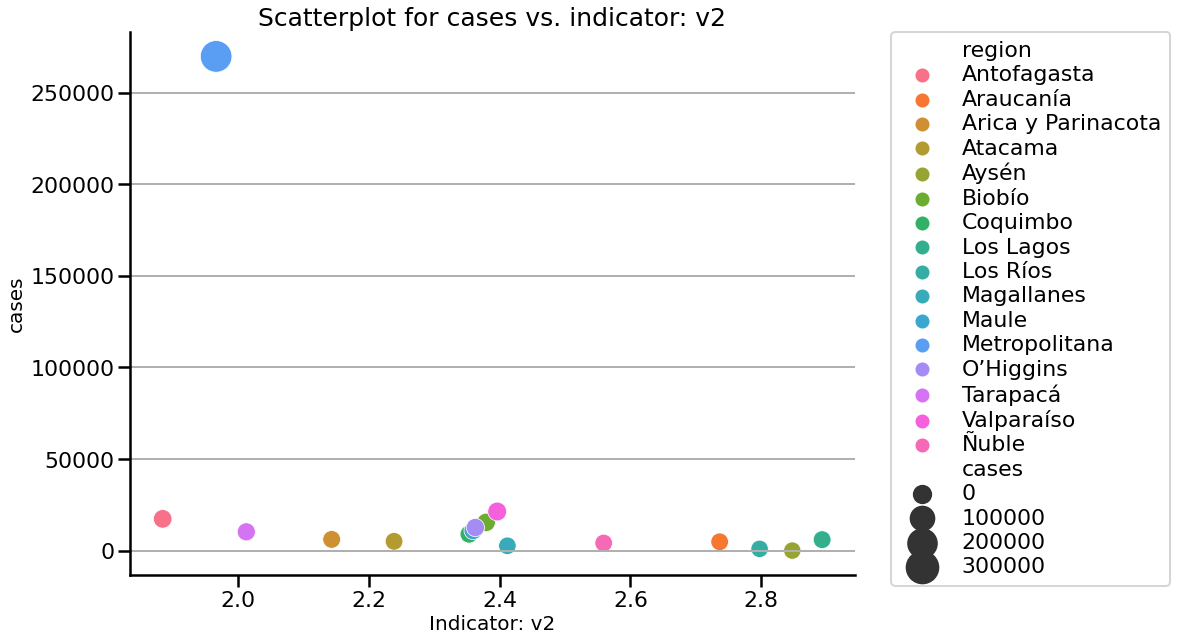

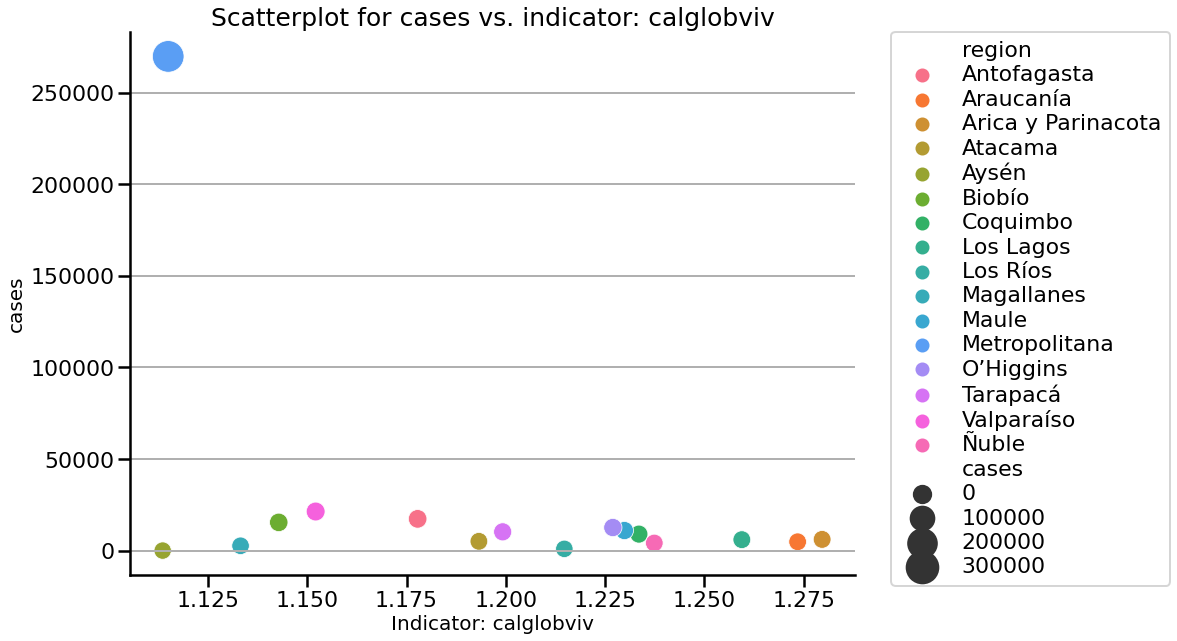

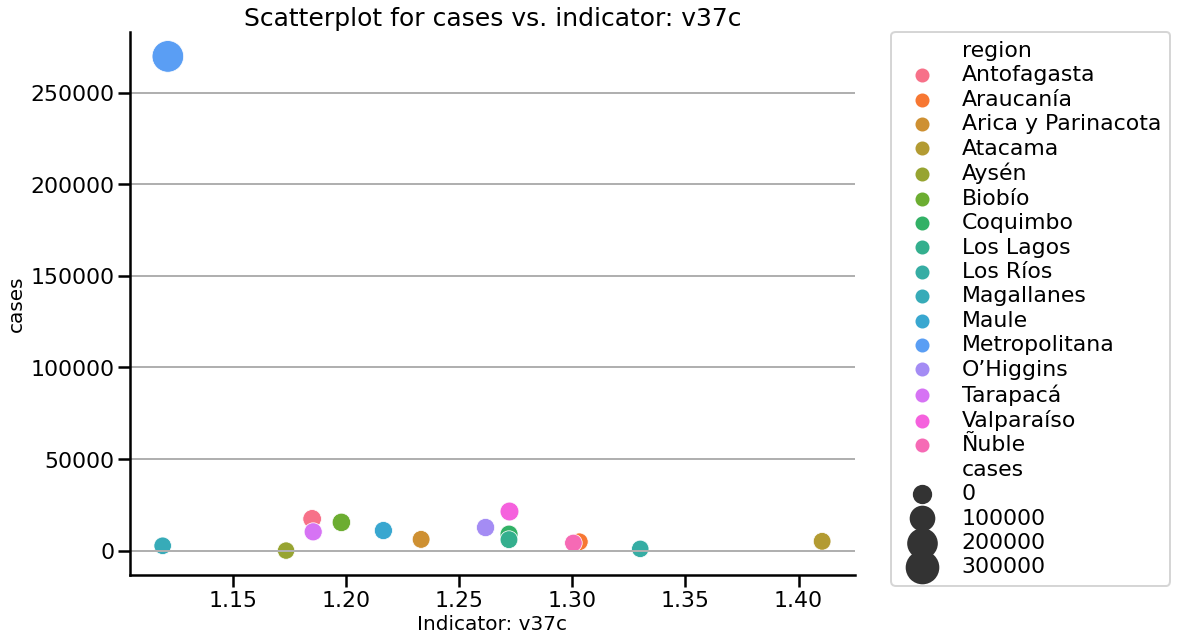

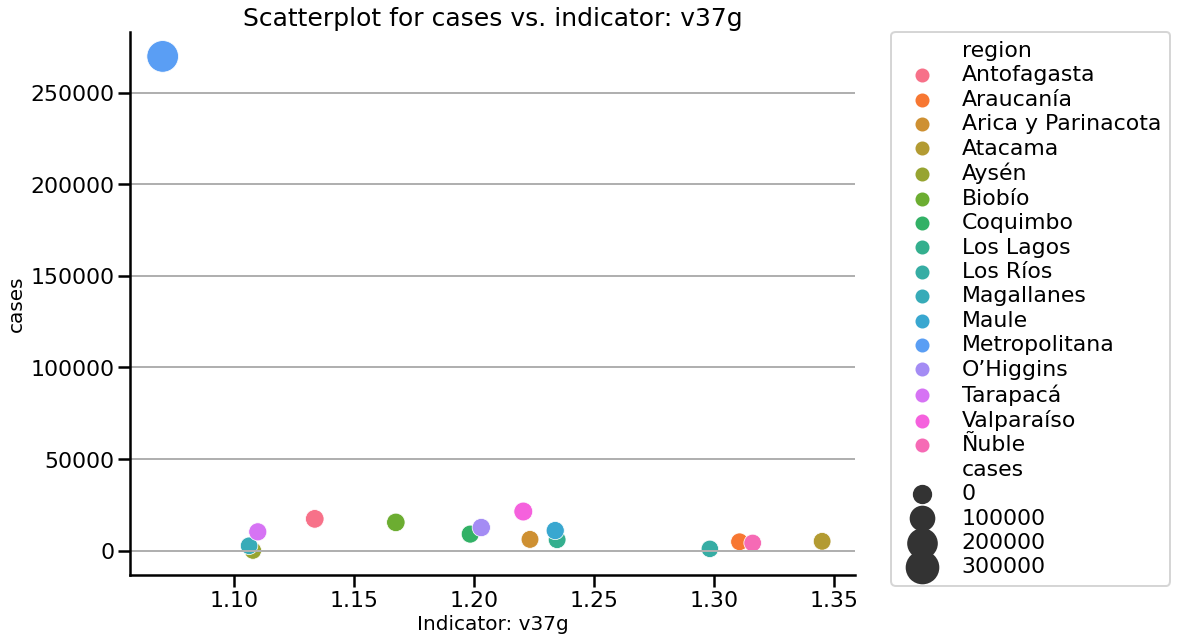

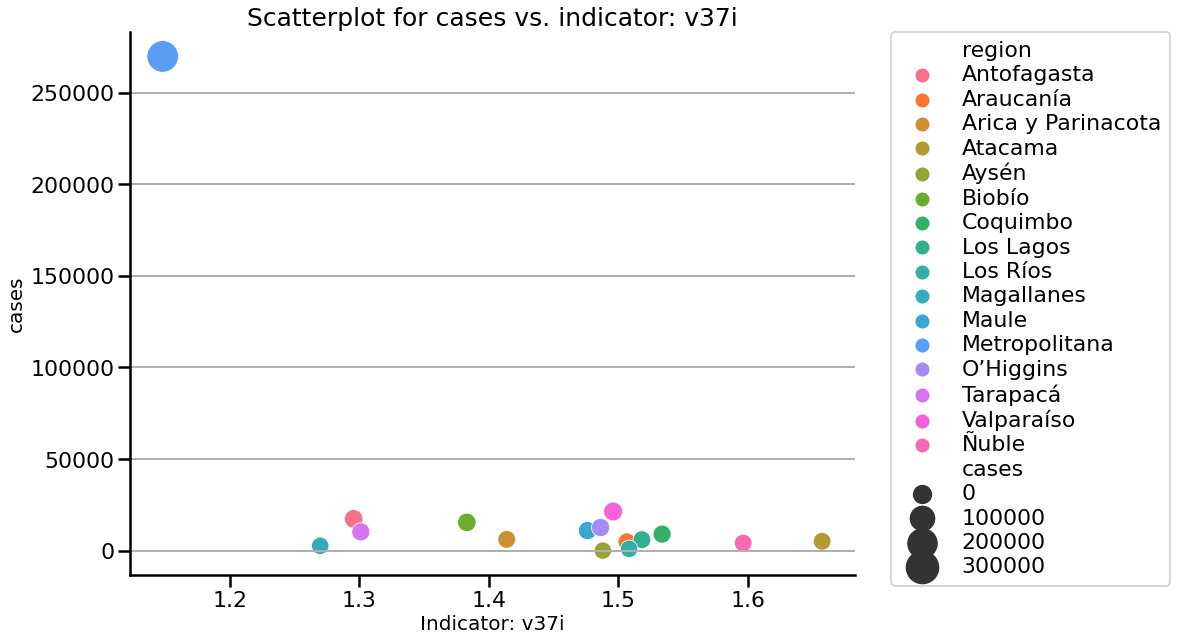

In [32]:
plot_indicator_vs_amount(transposed_cases, casen_rel, 'cases', 6, 6)

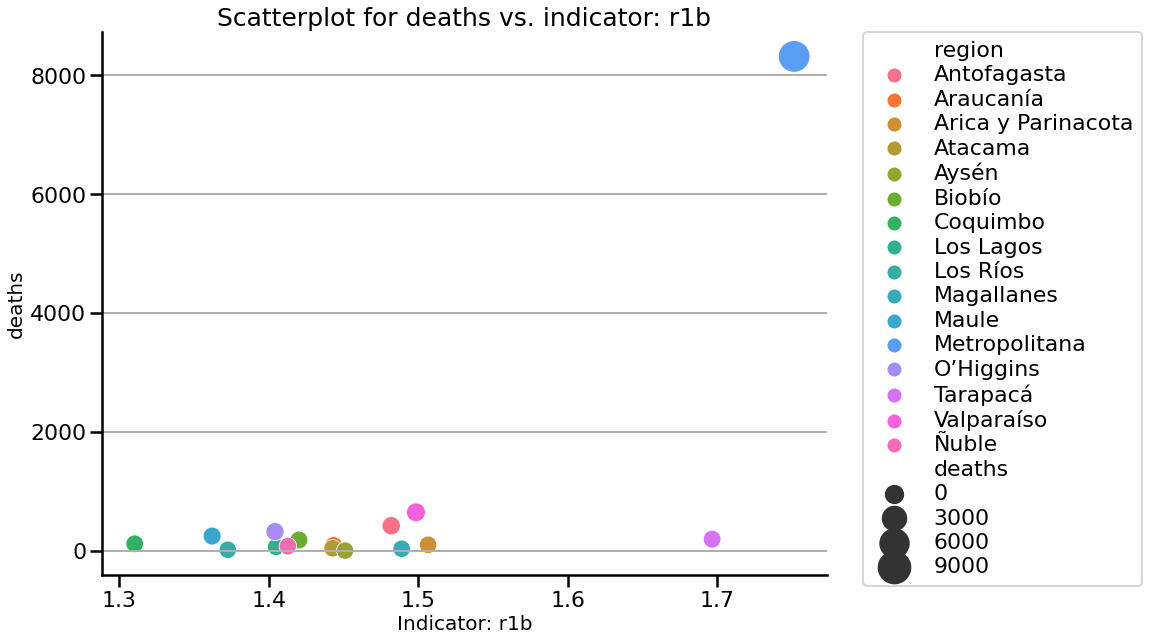

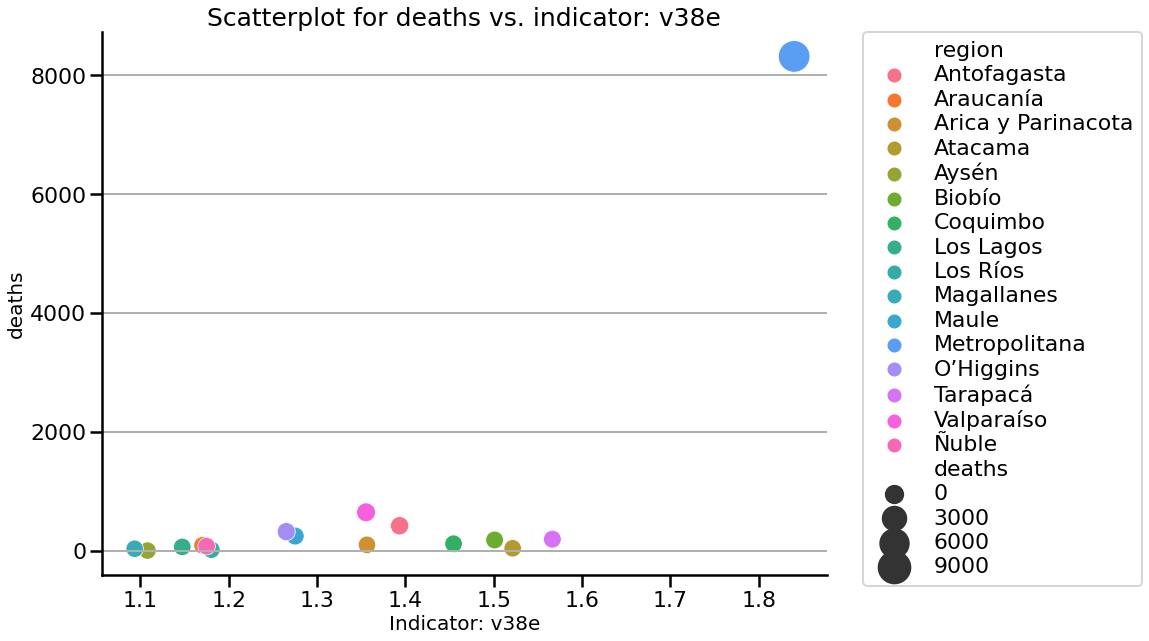

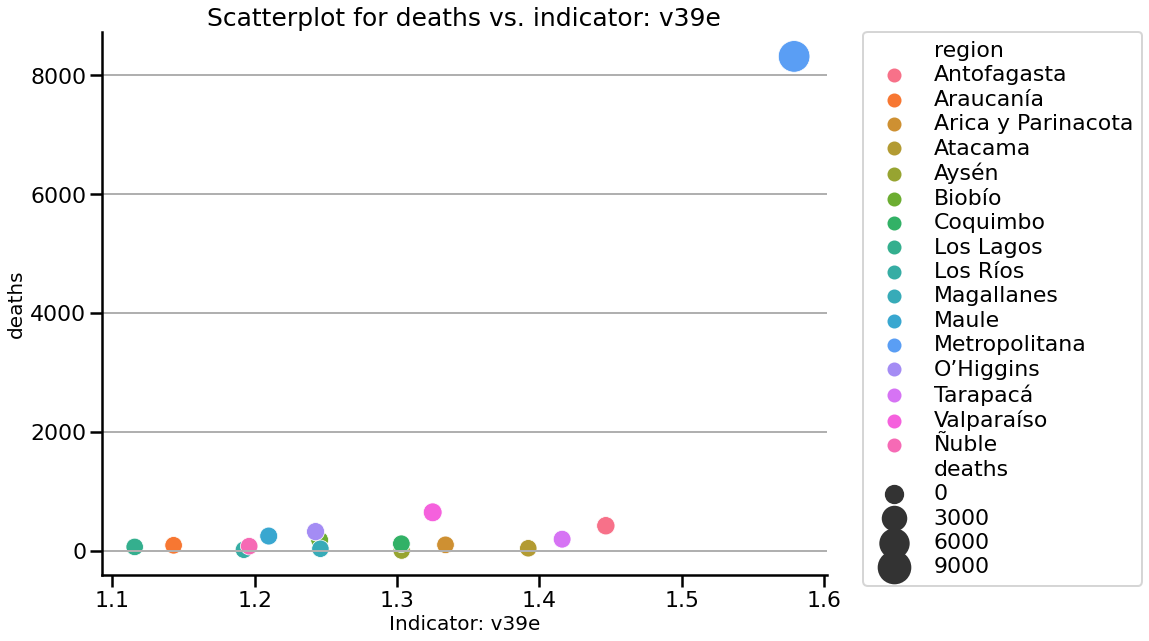

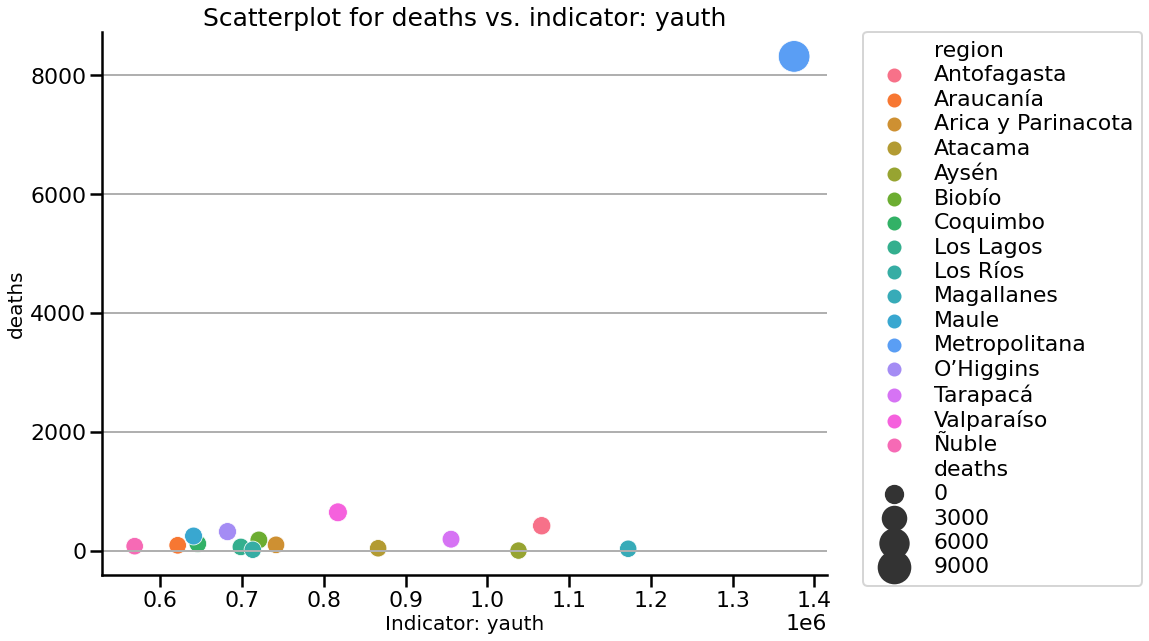

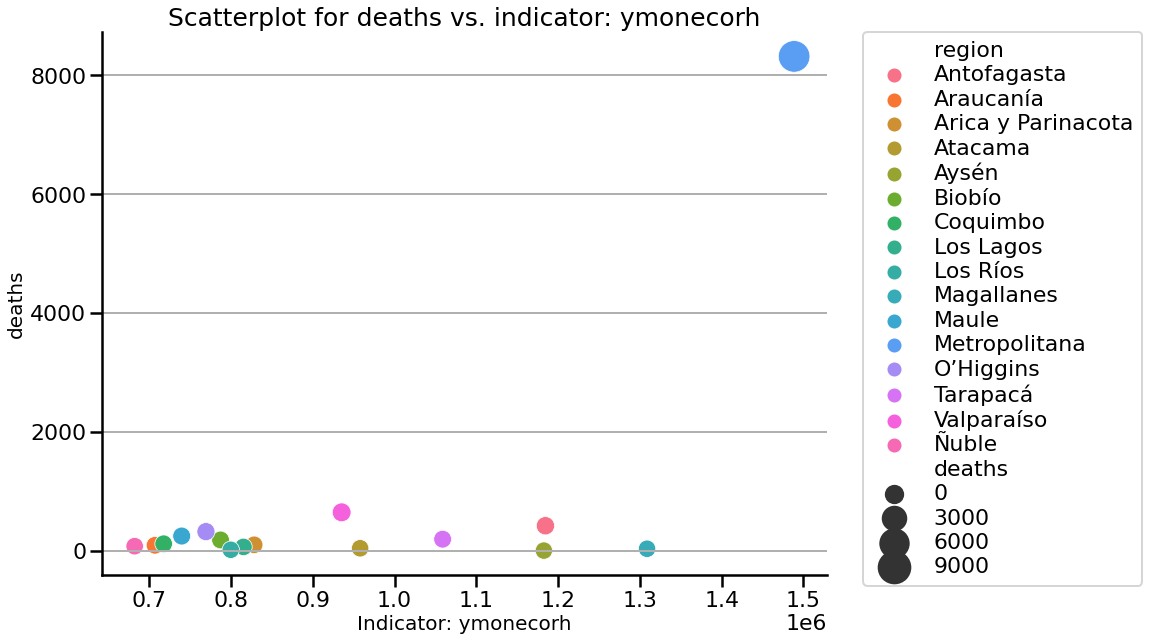

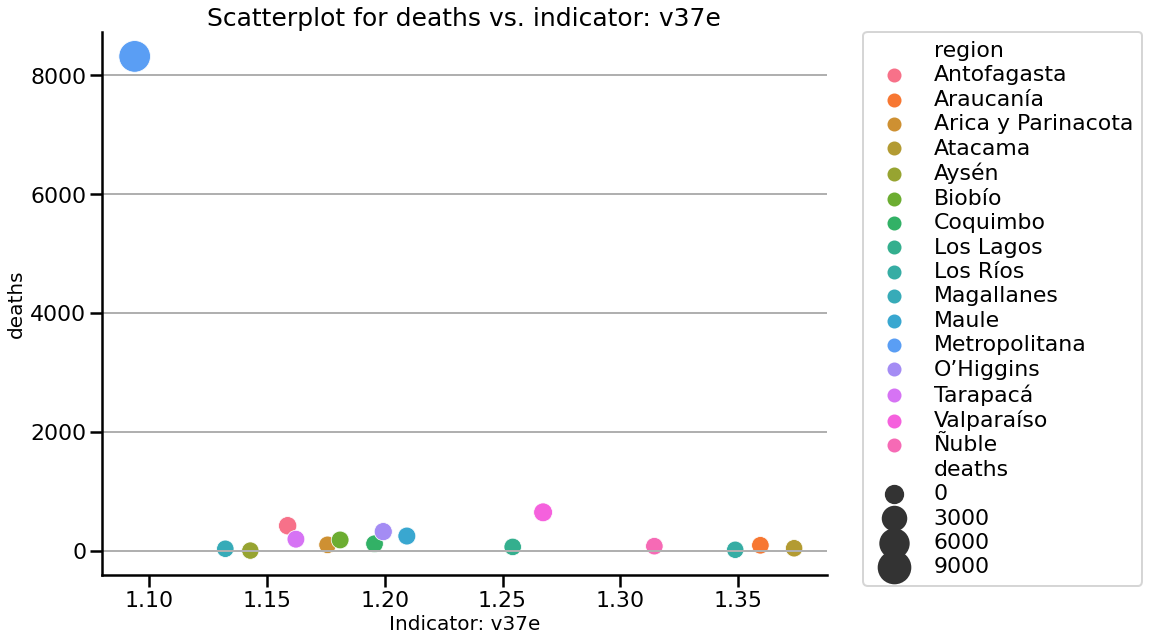

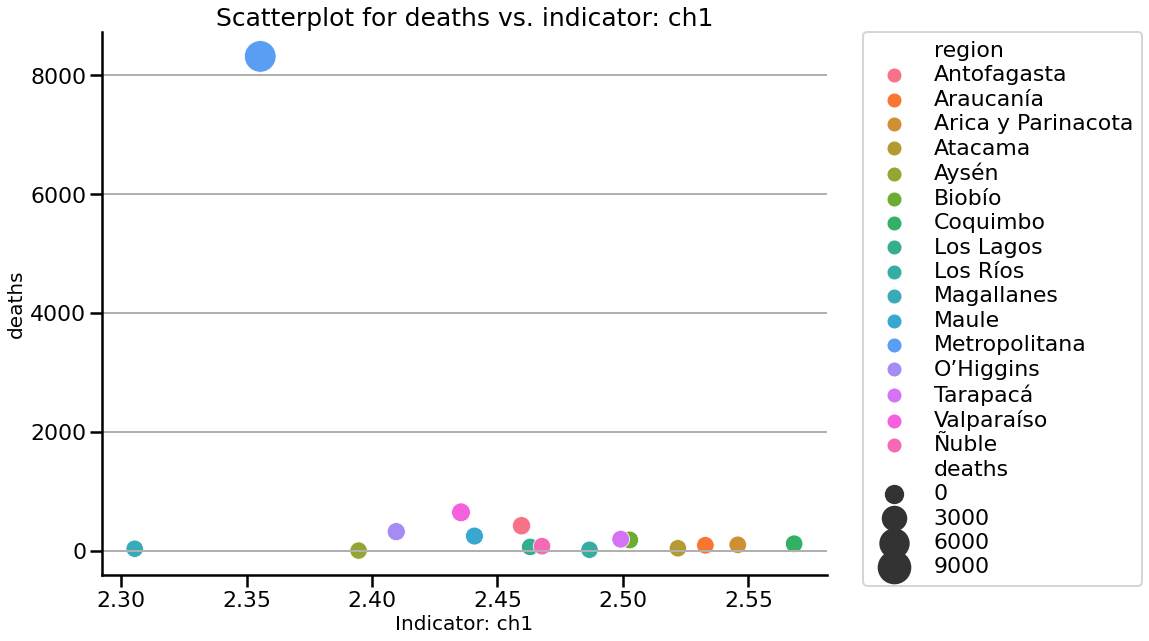

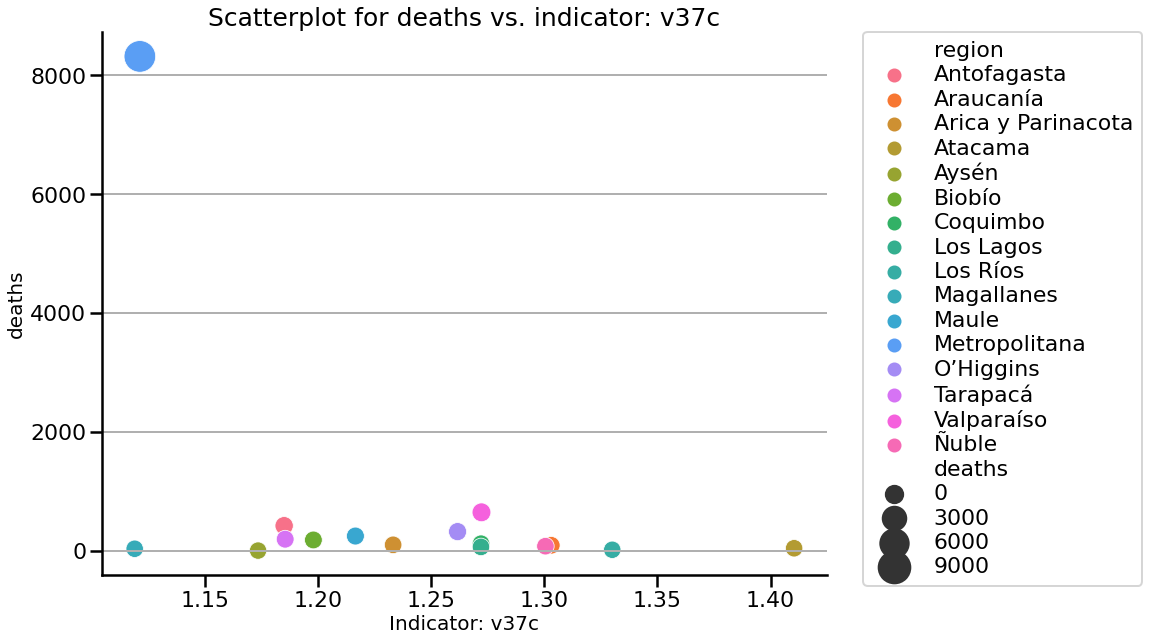

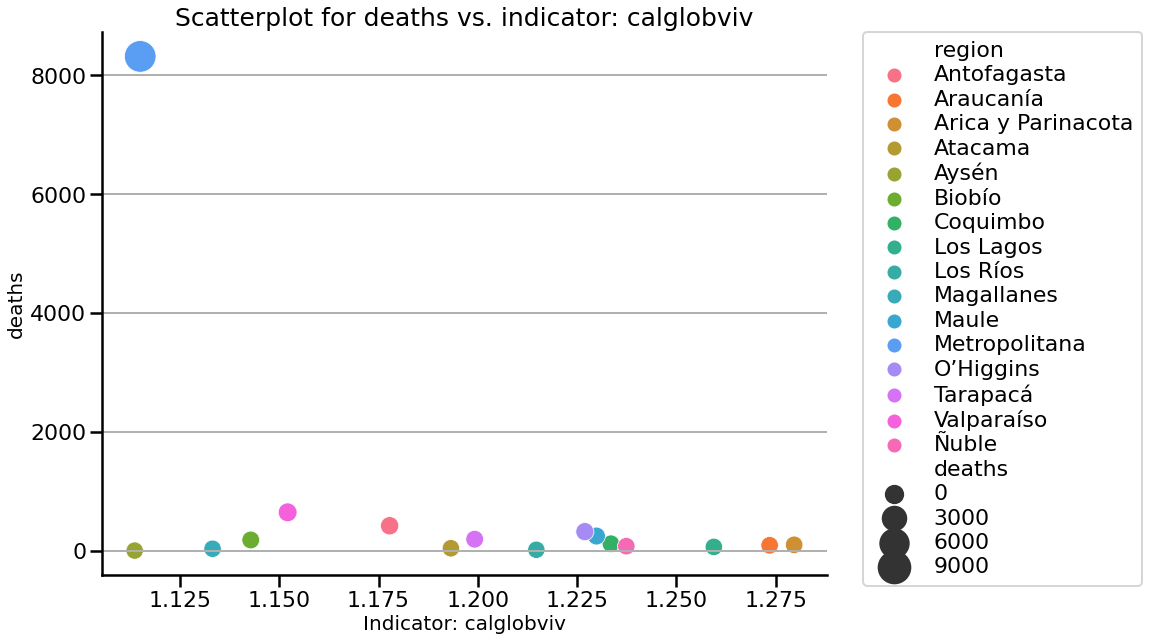

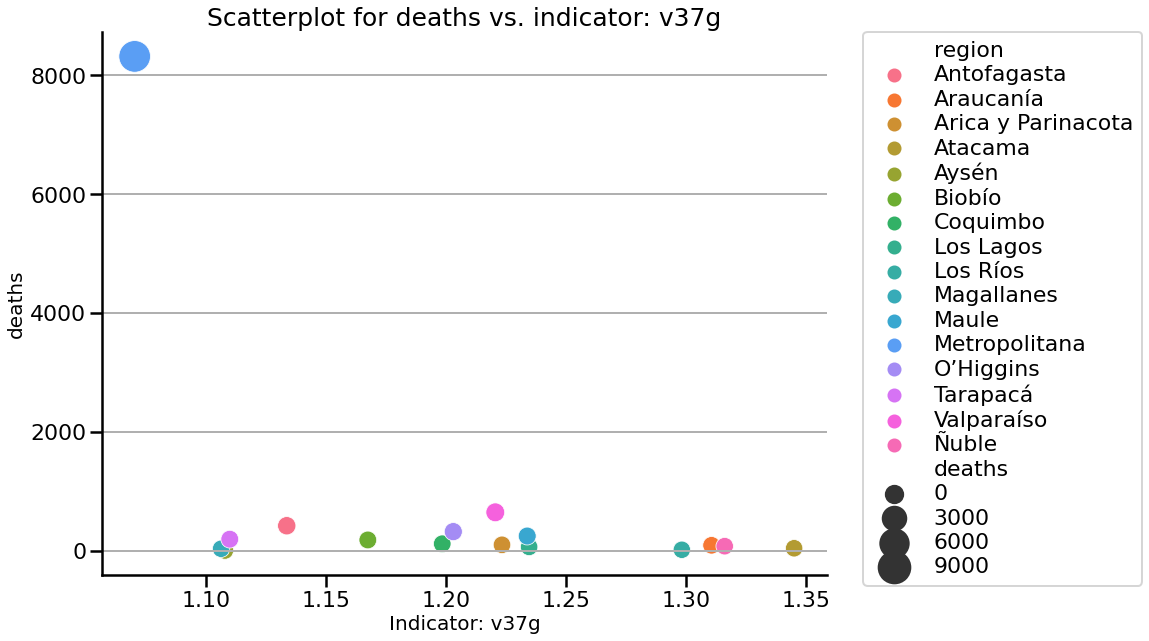

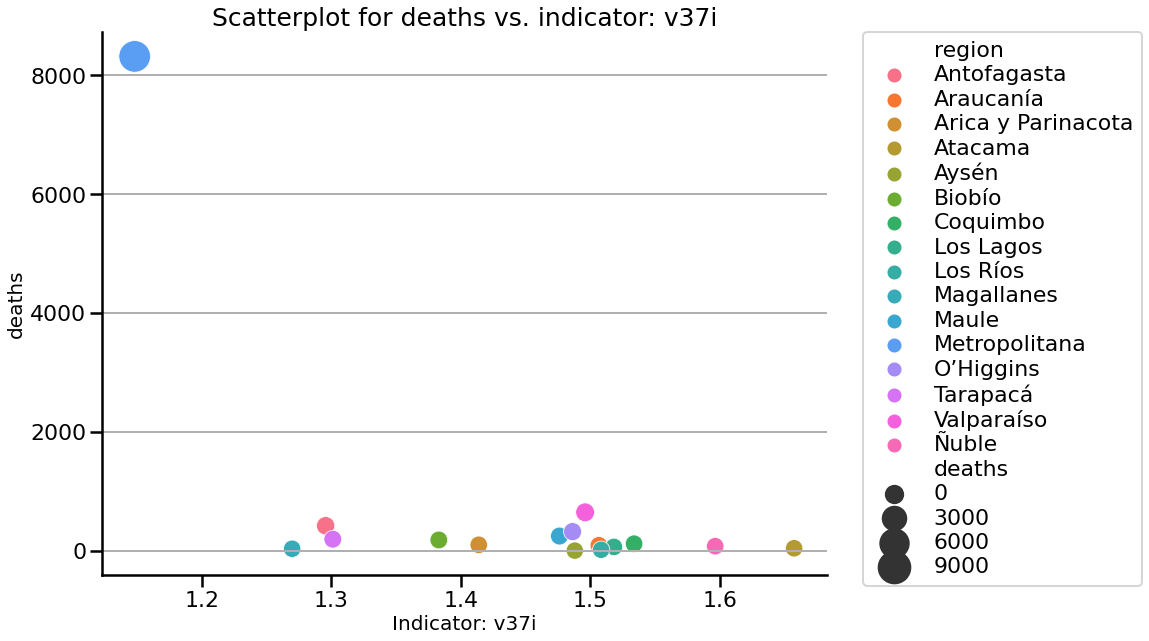

In [33]:
plot_indicator_vs_amount(transposed_deaths, casen_rel, 'deaths', 6, 6)

## 2. Correlation of Google mobility data with Covid-19 cases/deaths

In [35]:
mobility_merged_cases = merge_data(transposed_cases, mobility_chile, 'cases', input_casen=False)

get_corr(mobility_merged_cases, 'cases')

cases                    1.000000
residential              0.602417
parks                    0.427213
grocery_and_pharmacy     0.368845
transit_stations         0.366929
retail_and_recreation    0.229283
workplaces              -0.304832
dtype: float64

In [36]:
mobility_merged_deaths = merge_data(transposed_deaths, mobility_chile, 'deaths', input_casen=False)

get_corr(mobility_merged_deaths, 'deaths')

deaths                   1.000000
residential              0.597348
parks                    0.427882
grocery_and_pharmacy     0.366890
transit_stations         0.352028
retail_and_recreation    0.225037
workplaces              -0.309145
dtype: float64

# <a class="anchor" id="part-iv">Part IV: Build a Machine Learning model for time series prediction</a>

## Prepare data and model selection to predict the number of Covid-19 cases

In [45]:
def prepare_covid_data(df, title, region, start, end): 
    """
    Function to provide a melted DataFrame with Covid-19 cases/deaths for a specific region.   
    
    Input: 
        df (DataFrame): DataFrame with information about Covid-19 cases/deaths in Chile
        title (string): Specify the kind of the plot (cases or deaths) 
        region (string): Specify the region. 
        start (string): First day of mobility data
        end (string): Last day of mobility data
        
    Output: 
        df_melt (DataFrame): DataFrame with amount of cases/deaths for each day
    """
    

    # Select only the time that we have mobility data
    df = df[(df['Region'] >= start) & (df['Region'] <= end)]

    # Apply pandas melt 
    df_melt = pd.melt(
        df, id_vars = 'Region', 
        value_vars = df.columns.drop('Region'),
        value_name=title,
        var_name='regions'
    )

    # Sort out the rows without cases/deaths, and get only the data for a specific region
    df_melt = df_melt[(df_melt[title] != 0) & (df_melt['regions'] == region)]

    # Rename columns
    df_melt.columns = ['date', 'regions', title]

    # Create column with new cases/deaths per day
    df_melt['new_{}'.format(title)] = df_melt.groupby('regions')[title].diff()

    # Create new column with the value of the day before
    df_melt.loc[:,'yesterday'] = df_melt.loc[:,'new_{}'.format(title)].shift()
    
    # Drop old cases/deaths column
    # df_melt = df_melt.drop([title], axis = 1)

    # Set date column as index
    # df_melt = df_melt.set_index('date')

    # Fill NaN in first column with 0
    df_melt = df_melt.fillna(0)

    df_melt.insert(0, 'days', range(len(df_melt)))
    
    # Create new dummy column for region
    # df_melt[region] = 1
    
    # Drop regions column
    # df_melt = df_melt.drop(['regions'], axis = 1)

    return df_melt
    
df_melt = prepare_covid_data(cases_regions, 'cases', 'Metropolitana', '2020-03-04', '2020-08-07')

df_melt.head()


,days,date,regions,cases,new_cases,yesterday
942,0,2020-03-04,Metropolitana,1.0,0.0,0.0
943,1,2020-03-05,Metropolitana,2.0,1.0,0.0
944,2,2020-03-06,Metropolitana,3.0,1.0,1.0
945,3,2020-03-07,Metropolitana,4.0,1.0,1.0
946,4,2020-03-08,Metropolitana,6.0,2.0,1.0


In [100]:
def df_all_regions_mobility(df, title, start, end):
    """
    Function to prepare a DataFrame with the Covid-19 data for all regions and 
    merge it to the corresponding mobility data. 
    
    Input: 
        df (DataFrame): DataFrame with information about Covid-19 cases/deaths in Chile
        title (string): Specify the kind of the plot (cases or deaths) 
        start (string): First day of mobility data
        end (string): Last day of mobility data

    Output: 
        df_melt_mobility (DataFrame): DataFrame with cases/deaths data and mobility data. 
    
    """
    
    # Define list of all regions 
    regions_list = ['Arica y Parinacota', 'Tarapacá', 'Antofagasta', 'Atacama',
           'Coquimbo', 'Valparaíso', 'Metropolitana', 'O’Higgins', 'Maule',
           'Ñuble', 'Biobío', 'Araucanía', 'Los Ríos', 'Los Lagos', 'Aysén',
           'Magallanes']

    # Create empty DataFrame
    df_melt_all = pd.DataFrame()

    # Add results of prepare_covid_data for each region
    for item in regions_list:
        df_melt_all = pd.concat([df_melt_all, prepare_covid_data(df, title, item, start, end)])

    # Merge with mobility data
    df_melt_mobility = df_melt_all.merge(mobility_chile, left_on = ['regions', 'date'], right_on = ['sub_region_1', 'date'], how = 'left')

    # Create dummies for regions and add them to DataFrame
    region_dummies = pd.get_dummies(df_melt_mobility['regions'])
    df_melt_mobility = pd.concat([df_melt_mobility, region_dummies], axis = 1)

    # Drop columns that are not necessary
    df_melt_mobility = df_melt_mobility.drop(['sub_region_1'], axis = 1)

    # Set 'date' column as index
    df_melt_mobility = df_melt_mobility.set_index('date')

    # Given that there are son NaNs in the residential mobility column, we drop them
    df_melt_mobility = df_melt_mobility.dropna(axis = 0, how = 'any')
    
    # Sort DataFrame by index
    df_melt_mobility = df_melt_mobility.sort_index()

    return df_melt_mobility

df_mobility_cases = df_all_regions_mobility(cases_regions, 'cases', '2020-03-04', '2020-08-07')

# Get DataFrame with only num-values
df_mobility_cases_num = df_mobility_cases.drop('regions', axis = 1)
df_mobility_cases_num.head()

,days,cases,new_cases,yesterday,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,...,Coquimbo,Los Lagos,Los Ríos,Magallanes,Maule,Metropolitana,O’Higgins,Tarapacá,Valparaíso,Ñuble
date,,,,,,,,,,,,,,,,,,,,,
2020-03-04,0,2.0,0.0,0.0,-9.200000,1.000000,-19.000000,-11.000000,21.600000,-0.600000,...,0,0,0,0,1,0,0,0,0,0
2020-03-04,0,1.0,0.0,0.0,2.571429,13.857143,11.857143,10.714286,15.000000,-0.714286,...,0,0,0,0,0,1,0,0,0,0
2020-03-05,1,2.0,1.0,0.0,3.000000,12.285714,10.428571,6.000000,16.571429,-0.571429,...,0,0,0,0,0,1,0,0,0,0
2020-03-05,1,2.0,0.0,0.0,-7.600000,0.750000,-20.600000,-9.750000,22.600000,-0.800000,...,0,0,0,0,1,0,0,0,0,0
2020-03-06,2,2.0,0.0,0.0,-4.000000,1.500000,-17.600000,-9.750000,22.800000,-0.800000,...,0,0,0,0,1,0,0,0,0,0


In [101]:
def get_train_test_set(df, title, split_date): 
    """
    Function to provide the train and test datasets. Given that we have time series data, 
    I will split the data on a specific date. 
    
    Input: 
       df (DataFrame): DataFrame with information of Covid-19 cases/deaths and other features.
       The DataFrame must contain only numeric values. 
       title (string): Specify the kind of the plot (cases or deaths)
       split_date (string): Specify the date for splitting up the data (yyyy-mm-dd)
       
    Output: 
        X_train (DataFrame): Features to train the algorithm
        y_train (Series): Target values for training
        X_test (DataFrame): Features to test the algorithm
        y_test (Series): Target values for testing
    
    """
       
    X_train = df[:split_date].drop(['new_{}'.format(title)], axis = 1)
    y_train = df.loc[:split_date, 'new_{}'.format(title)]
    X_test = df[pd.to_datetime(split_date) + timedelta(days=1):].drop(['new_{}'.format(title)], axis = 1)
    y_test = df.loc[pd.to_datetime(split_date) + timedelta(days=1):, 'new_{}'.format(title)]
    
    return X_train, y_train, X_test, y_test

In [102]:
X_train, y_train, X_test, y_test = get_train_test_set(df_mobility_cases_num, 'cases', '2020-06-30')

In [103]:
def try_different_models(X_train, y_train, n, scoring='r2'):
    """
    Function to try different ML-models to select one for further analysis. 
    Prints score value and boxplot of cross validation results. 
    
    Input: 
        X_train (DataFrame): Features to train the algorithm
        y_train (Series): Target values for training
        n (int): Number of splits in TimeSeriesSplit
        scoring (string): Type of scoring
        
    Output: 
        Prints score values for the different models. 
        Plots boxplot with cross validation results. 

    """
    
    
    # Store models in list
    models = []
    models.append(('LR', LinearRegression()))
    models.append(('KNN', KNeighborsRegressor())) 
    models.append(('RF', RandomForestRegressor(n_estimators = 100, random_state = 42)))
    models.append(('SVR', SVR(gamma='auto')))

    results = []
    names = []
    for name, model in models:

        # TimeSeries split
        tscv = TimeSeriesSplit(n_splits=n)

        # TimeSeries Cross validation
        cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring=scoring)
        results.append(cv_results)
        names.append(name)

        # Print results
        print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

    # Plot boxplot for each model
    plt.boxplot(results, labels=names)
    plt.title('Algorithm Comparison')
    plt.show() 

LR: 0.024997 (2.409527)
KNN: 0.130266 (1.988711)
RF: 0.110037 (1.900991)
SVR: -0.126698 (0.071984)


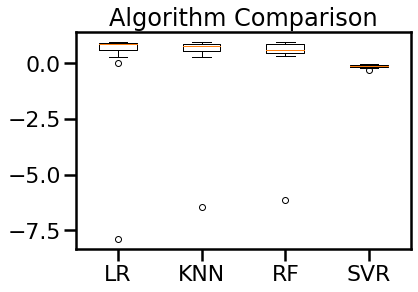

In [104]:
try_different_models(X_train, y_train, 12, 'r2')

## Apply Grid Search to improve hyperparameters

In [44]:
def regression_metrics(y_true, y_pred):
    """
    Function to print different metrics to evaluate the regression model. 
    
    Input: 
        y_true (array): True values of the validation set
        y_pred (array): Predicted values
        
    Output: 
        explained_variance
        mean_squared_log_error
        r2
        MAE
        MSE
        RMSE
    """
    
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    
    mse = metrics.mean_squared_error(y_true, y_pred) 
    
    mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)   
    
    r2 = metrics.r2_score(y_true, y_pred)
    
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [106]:
def rmse(actual, predict):
    """
    Function to calculate the RMSE. 
    
    Input: 
        actual (array): True values
        predict (array): Predicted values
        
    Output: 
        score: RMSE score. 
    """
    
    predict = np.array(predict)
    actual = np.array(actual)
    
    distance = predict - actual
    square_distance = distance ** 2
    
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

In [116]:
def find_best_model(X_train, y_train, X_test, y_test, n):
    """
    Function to perform GridSearch to find the best parameters for the
    RandomForestRegressor. 
    
    Input: 
        X_train (DataFrame): Features to train the algorithm
        y_train (Series): Target values for training
        X_test (DataFrame): Features to test the algorithm
        y_test (Series): Target values for testing
        n (int): Number of splits in TimeSeriesSplit
    
    Output: 
        prints best_model
        prints score of best_model
        prints results of regression metrics
        best_model: RandomForestRegressor
    
    """
    
    # Define model
    model = RandomForestRegressor()

    # Define parameters for GridSearch
    param_search = { 
        'n_estimators': [20, 50, 100],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [i for i in range(5,15)]
    }   

    # Define TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n)

    # Perform GridSearch
    gsearch = GridSearchCV(
        estimator=model, 
        cv=tscv, 
        param_grid=param_search, 
        scoring = rmse_score)

    # Fit model on training data
    gsearch.fit(X_train, y_train)

    # Get best model
    best_model = gsearch.best_estimator_

    # Prepare values for regression metrics
    y_true = y_test.values
    y_pred = best_model.predict(X_test)

    # Print model, score and regression metrics
    print(best_model)
    print(regression_metrics(y_true, y_pred))
    
    return best_model

In [117]:
model_cases = find_best_model(X_train, y_train, X_test, y_test, 12)

RandomForestRegressor(max_depth=6, n_estimators=20)
explained_variance:  -1.064
mean_squared_log_error:  0.9123
r2:  -1.4697
MAE:  182.8058
MSE:  192366.934
RMSE:  438.5966
None


In [136]:
def plot_model_performance(model, X_train, X_test, y_test, m):
    """
    Function to plot a scatterplot of true values vs. predicted values and 
    a barplot to show the importance of the features for the best model. 
    
    Input: 
        model: RandomForestRegressor object
        X_train (DataFrame): Features to train the algorithm
        y_train (Series): Target values for training
        y_test (Series): Target values for testing
        m (int): Define how many features should appear in the barplot
        
    Output: 
        Seaborn scatterplot true values vs. predicted values
        Seaborn barplot importances of features
    """
    
    y_true = y_test.values
    y_pred = model.predict(X_test)
    
    # Scatterplot of true values vs. predicted values
    fix, ax = plt.subplots(figsize = (10,8))
    sns.scatterplot(y_true, y_pred, alpha = 0.6)
    plt.title('True values vs. predicted values', fontsize = 25)
    plt.xlabel('True values', fontsize = 20)
    plt.ylabel('Predicted values', fontsize = 20)
    plt.show()
    
    # Get feature importances and feature names
    imp = model.feature_importances_[:m]
    features = X_train.columns

    # Plot barplot of indices
    fix, ax = plt.subplots(figsize = (10,8))
    indices = np.argsort(imp)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), imp[indices], color='blue', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    

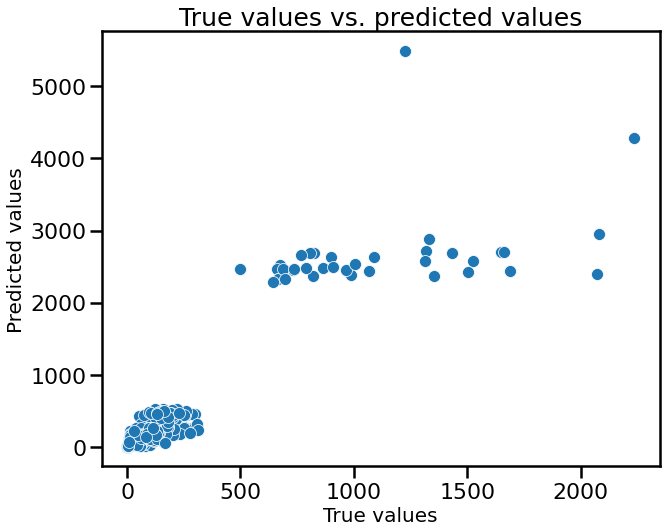

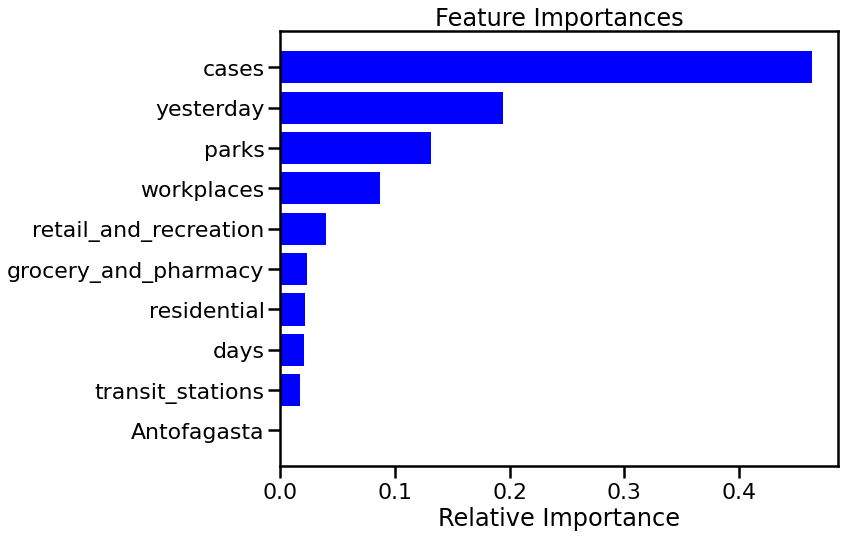

In [125]:
plot_model_performance(model_cases, X_train, X_test, y_test, 10)

## Further feature engineering: Add CASEN data

In [126]:
# Merge mobility_data with CASEN data
df_mobility_cases_casen = df_mobility_cases.reset_index().merge(casen_regions, left_on = 'regions', right_on = 'region', how = 'left').set_index('date')

df_mobility_cases_casen = df_mobility_cases_casen.drop(['regions', 'region'], axis = 1)

df_mobility_cases_casen.head()

,days,cases,new_cases,yesterday,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,...,numper,esc,educ,activ,indmat,indsan,calglobviv,iae,iai,hacinamiento
date,,,,,,,,,,,,,,,,,,,,,
2020-03-04,0,2.0,0.0,0.0,-9.200000,1.000000,-19.000000,-11.000000,21.600000,-0.600000,...,3.688505,9.936872,3.972514,1.943259,1.197659,1.110139,1.229879,1.038467,1.203511,1.130786
2020-03-04,0,1.0,0.0,0.0,2.571429,13.857143,11.857143,10.714286,15.000000,-0.714286,...,3.975571,11.705302,5.329804,1.791728,1.108073,1.030610,1.114974,1.098495,1.269196,1.195207
2020-03-05,1,2.0,1.0,0.0,3.000000,12.285714,10.428571,6.000000,16.571429,-0.571429,...,3.975571,11.705302,5.329804,1.791728,1.108073,1.030610,1.114974,1.098495,1.269196,1.195207
2020-03-05,1,2.0,0.0,0.0,-7.600000,0.750000,-20.600000,-9.750000,22.600000,-0.800000,...,3.688505,9.936872,3.972514,1.943259,1.197659,1.110139,1.229879,1.038467,1.203511,1.130786
2020-03-06,2,2.0,0.0,0.0,-4.000000,1.500000,-17.600000,-9.750000,22.800000,-0.800000,...,3.688505,9.936872,3.972514,1.943259,1.197659,1.110139,1.229879,1.038467,1.203511,1.130786


In [127]:
X_train_casen, y_train_casen, X_test_casen, y_test_casen = get_train_test_set(df_mobility_cases_casen, 'cases', '2020-06-30')

In [128]:
model_cases_casen = find_best_model(X_train_casen, y_train_casen, X_test_casen, y_test_casen, 12)

RandomForestRegressor(max_depth=8, n_estimators=20)
explained_variance:  -0.5208
mean_squared_log_error:  1.1309
r2:  -0.9695
MAE:  192.2602
MSE:  153405.9771
RMSE:  391.6708
None


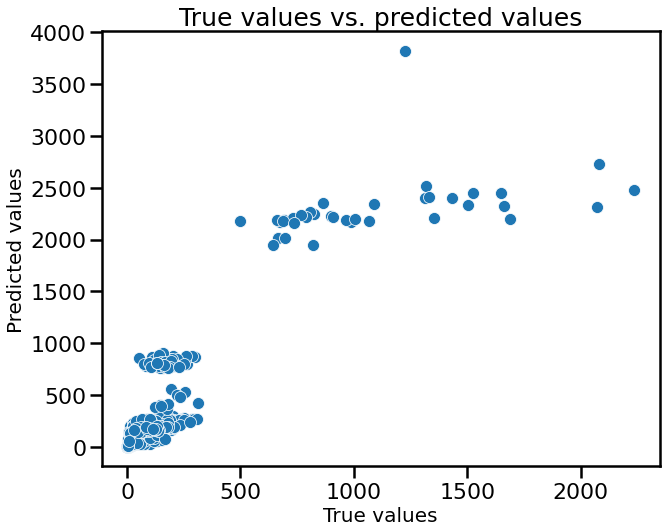

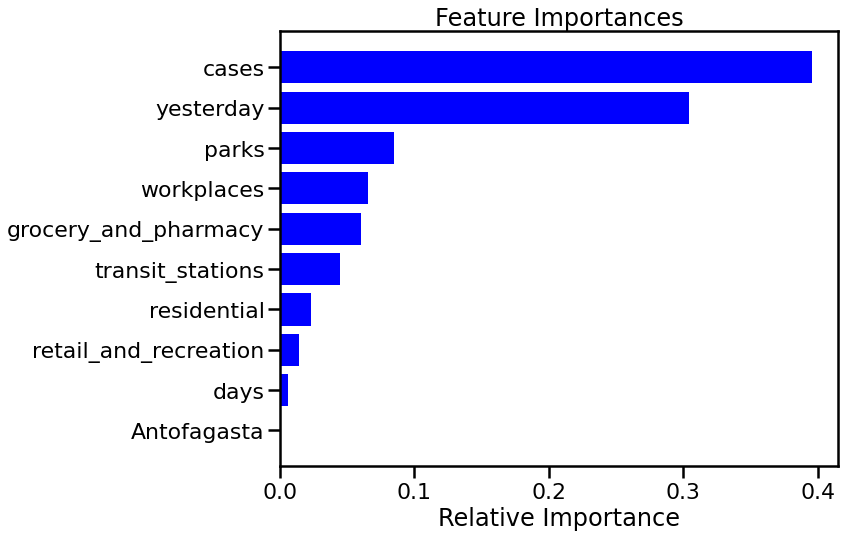

In [129]:
plot_model_performance(model_cases_casen, X_train_casen, X_test_casen, y_test_casen, 10)

## Prepare data and model selection to predict the number of Covid-19 fatalities

In [131]:
# Read in data about Covid-19 deaths
df_mobility_deaths = df_all_regions_mobility(deaths_regions, 'deaths', '2020-03-04', '2020-08-07')

# Some days show negative values for new fatalities (probably corrections), which broke the 
# algorithm before. 
df_mobility_deaths = df_mobility_deaths[df_mobility_deaths['new_deaths'] >= 0]

# Get DataFrame with only the num-values
df_mobility_deaths_num = df_mobility_deaths.drop('regions', axis = 1)

df_mobility_deaths_num.head()

,days,deaths,new_deaths,yesterday,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,...,Coquimbo,Los Lagos,Los Ríos,Magallanes,Maule,Metropolitana,O’Higgins,Tarapacá,Valparaíso,Ñuble
date,,,,,,,,,,,,,,,,,,,,,
2020-03-22,0,1.0,0.0,0.0,-64.285714,-39.285714,-54.714286,-58.166667,-35.714286,19.857143,...,0,0,0,0,0,1,0,0,0,0
2020-03-23,1,1.0,0.0,0.0,-50.571429,-30.000000,-41.571429,-48.714286,-36.714286,23.428571,...,0,0,0,0,0,1,0,0,0,0
2020-03-24,2,2.0,1.0,0.0,-51.285714,-29.142857,-43.428571,-48.428571,-39.857143,24.000000,...,0,0,0,0,0,1,0,0,0,0
2020-03-25,0,1.0,0.0,0.0,-65.500000,-44.500000,-63.000000,-63.000000,-44.250000,24.000000,...,0,0,0,0,0,0,0,0,0,0
2020-03-25,3,2.0,0.0,1.0,-51.857143,-29.142857,-43.285714,-48.428571,-40.428571,24.857143,...,0,0,0,0,0,1,0,0,0,0


In [132]:
X_train_deaths, y_train_deaths, X_test_deaths, y_test_deaths = get_train_test_set(df_mobility_deaths_num, 'deaths', '2020-06-30')

LR: 0.481937 (0.400583)
KNN: 0.562798 (0.237933)
RF: 0.485153 (0.274046)
SVR: -0.053281 (0.021878)


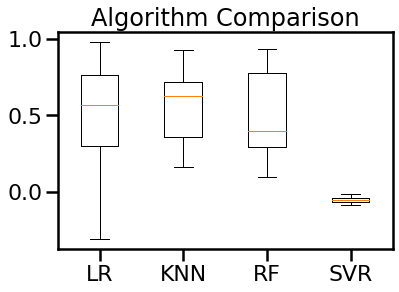

In [133]:
try_different_models(X_train_deaths, y_train_deaths, 12, 'r2')

In [134]:
model_deaths = find_best_model(X_train_deaths, y_train_deaths, X_test_deaths, y_test_deaths, 12)

RandomForestRegressor(max_depth=9, max_features='log2', n_estimators=50)
explained_variance:  0.1618
mean_squared_log_error:  2.1119
r2:  0.1246
MAE:  10.5362
MSE:  1220.4336
RMSE:  34.9347
None


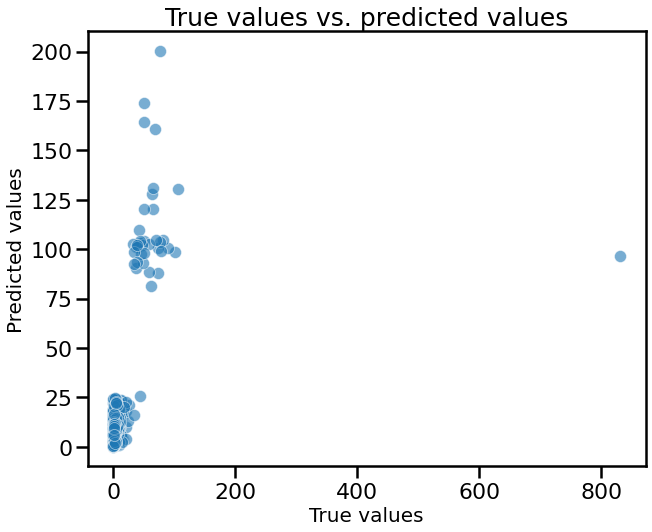

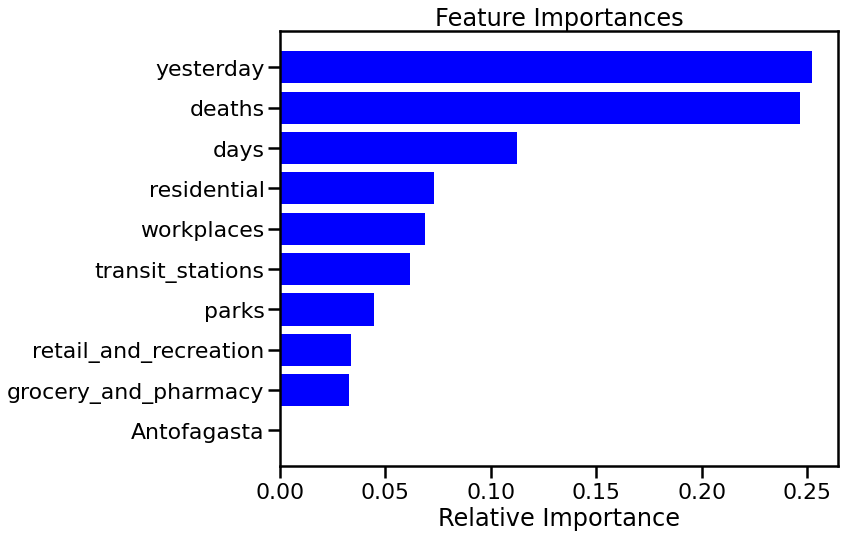

In [137]:
plot_model_performance(model_deaths, X_train_deaths, X_test_deaths, y_test_deaths, 10)

## Further Feature Engineering: add CASEN data

In [138]:
# Merge mobility_data with CASEN data
df_mobility_deaths_casen = df_mobility_deaths.reset_index().merge(casen_regions, left_on = 'regions', right_on = 'region', how = 'left').set_index('date')

df_mobility_deaths_casen_num = df_mobility_deaths_casen.drop(['regions', 'region'], axis = 1)

df_mobility_deaths_casen_num.head()

,days,deaths,new_deaths,yesterday,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,...,numper,esc,educ,activ,indmat,indsan,calglobviv,iae,iai,hacinamiento
date,,,,,,,,,,,,,,,,,,,,,
2020-03-22,0,1.0,0.0,0.0,-64.285714,-39.285714,-54.714286,-58.166667,-35.714286,19.857143,...,3.975571,11.705302,5.329804,1.791728,1.108073,1.030610,1.114974,1.098495,1.269196,1.195207
2020-03-23,1,1.0,0.0,0.0,-50.571429,-30.000000,-41.571429,-48.714286,-36.714286,23.428571,...,3.975571,11.705302,5.329804,1.791728,1.108073,1.030610,1.114974,1.098495,1.269196,1.195207
2020-03-24,2,2.0,1.0,0.0,-51.285714,-29.142857,-43.428571,-48.428571,-39.857143,24.000000,...,3.975571,11.705302,5.329804,1.791728,1.108073,1.030610,1.114974,1.098495,1.269196,1.195207
2020-03-25,0,1.0,0.0,0.0,-65.500000,-44.500000,-63.000000,-63.000000,-44.250000,24.000000,...,3.727644,10.637657,4.344789,1.997066,1.078627,1.077559,1.142811,1.045374,1.233420,1.124930
2020-03-25,3,2.0,0.0,1.0,-51.857143,-29.142857,-43.285714,-48.428571,-40.428571,24.857143,...,3.975571,11.705302,5.329804,1.791728,1.108073,1.030610,1.114974,1.098495,1.269196,1.195207


In [139]:
X_train_deaths_casen, y_train_deaths_casen, X_test_deaths_casen, y_test_deaths_casen = get_train_test_set(df_mobility_deaths_casen_num, 'deaths', '2020-06-30')

In [140]:
model_deaths_casen = find_best_model(X_train_deaths_casen, y_train_deaths_casen, X_test_deaths_casen, y_test_deaths_casen, 12)

RandomForestRegressor(max_depth=10, max_features='log2', n_estimators=50)
explained_variance:  0.1073
mean_squared_log_error:  0.5531
r2:  0.1062
MAE:  6.4795
MSE:  1245.9927
RMSE:  35.2986
None


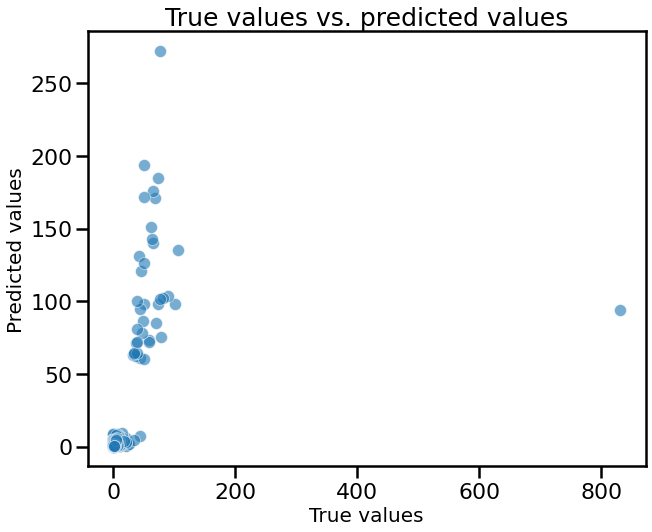

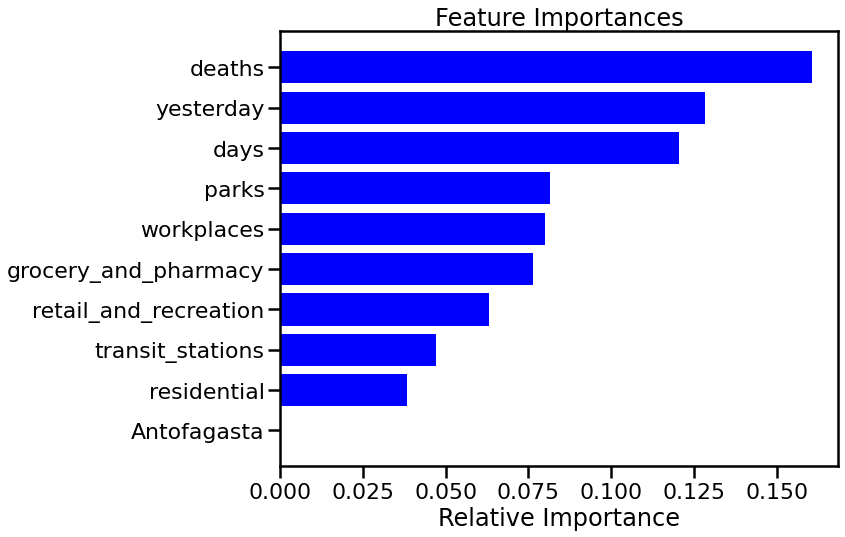

In [141]:
plot_model_performance(model_deaths_casen, X_train_deaths_casen, X_test_deaths_casen, y_test_deaths_casen, 10)